<a href="https://colab.research.google.com/github/jsrobson/2023-cis5450-termproject/blob/main/CIS5450_TermProject_07_STR_Feature_Review_COMPLETE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: STR Feature Review

This is the third of three notebooks that apply a modelling approach to the data we have sourced, cleaned, and collated.

*Description:* As a corollary to the main study question concerning the relationship between STR frequency and property prices by borough in [inner London](https://en.wikipedia.org/wiki/Inner_London), we consider the relationship between the pricing of an STR property on a weekly basis and several geographic, programmatic (i.e. rules-driven factors), and quality-of-life based factors. That is, what are the factors that influence the dependent variable of cumulative weekly pricing?

Where academics in discplines of economics, sociology, and urban planning consider our main study question, the corollary question we have posed is often the domain of entrepreneurs, real estate investors, and software developers interested in the housing investment sector. However, we will consider this corollary question from the lens of our central focus: given a comprehensive dataset of STR instances and their defining features, what might we learn about the factors that are correlated to STR pricing and what might that tell us about the influence of STRs on an urban housing market?

1. File initialization
2. Data loading
3. Data cleaning and exploratory data analysis
4. Linear Model Selection I: Non-neural methods
5. Linear Model Selection II: Neural Network
6. Conclusions

*Data:* In this adjunct notebook, we use a detailed variant of the listings data derived from [Inside Airbnb](http://insideairbnb.com/explore/) to perform data analysis and linear regression modelling of various types to derive insights about these influencing factors. The notebook is divided into sections to ensure readability:

*Return:* An understanding of the feature importance of STR offerings in inner London following a series of modelling approaches.

# 1. File initialization
In this section, we import libraries, initialize filepaths, and reuse predefined dataloader functions from [Load Data](https://colab.research.google.com/drive/1MXdBZLM5Yw3anvdrP-qozn7MHs_6SzDw?usp=sharing) notebook.

In [ ]:
# package installs
!pip install geopandas
!pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 26.7 MB/s eta 0:00:00


In [ ]:
# import libraries
from collections import defaultdict

from dask import dataframe as dd
from google.colab import drive

from scipy.stats import zscore

from sklearn import linear_model, metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# for reference, set max display rows
pd.set_option('display.max_rows', 100)
sns.set(font_scale=0.5)

In [ ]:
# instantiate needed filepaths
filepath_boroughs = "/content/drive/MyDrive/CIS5450/Term_Project/data/ldn_borough/ldn_borough.csv"
filepath_listings_detail = "/content/drive/MyDrive/CIS5450/Term_Project/data/ldn_airbnb/listings_detail.csv"
filepath_shapefile = "/content/drive/MyDrive/CIS5450/Term_Project/data/shapefile/London_Borough_Excluding_MHW.shp"

In [ ]:
# borrow from data loader class
def read_boroughs_to_list(filepath):
    # read file
    file_in = pd.read_csv(filepath, dtype={"neighbourhood": "str"})
    # filter by inner boroughs
    file_in = file_in[file_in['location'] == 'inner']
    # return boroughs as list
    return file_in['neighbourhood'].values.tolist()

boroughs = read_boroughs_to_list(filepath_boroughs)
# rename City of Westminster to Wesminster, as convention demands
boroughs = list(map(lambda b: "Westminster" if b == "City of Westminster" else b, boroughs))

# 2. Data loading
*Description:* In this section, we use the Dask library to parallelize data loading on a large dataset of detailed listing data for STR rentals in London (>315 MB).

*Data:* The data that forms the basis of this notebook investigation is detailed Airbnb listing data for the period ending in mid-2020; this is the 'complete' companion to the condensed dataset used elsewhere in this project. This dataset is prepared by advocacy group [Inside Airbnb](http://insideairbnb.com/explore/), and is drawn from their data archive.

In [ ]:
# function to read csv to dask dataframe
def read_list_detail_to_df(filepath):
  # set parsing engine to python and skip on bad lines to prevent errors
  return dd.read_csv(filepath, dtype=str, engine="python", on_bad_lines='skip',)

# read csv to dask dataframe
df = read_list_detail_to_df(filepath_listings_detail)
# print first three rows as sanity check
df.head(3)

id                         listing_url       scrape_id last_scraped  \
0  11551  https://www.airbnb.com/rooms/11551  20200611182946   2020-06-16   
1  13913  https://www.airbnb.com/rooms/13913  20200611182946   2020-06-16   
2  15400  https://www.airbnb.com/rooms/15400  20200611182946   2020-06-16   

                                         name  \
0  Arty and Bright London Apartment in Zone 2   
1         Holiday London DB Room Let-on going   
2         Bright Chelsea  Apartment. Chelsea!   

                                             summary  \
0  Unlike most rental apartments out there my fla...   
1  My bright double bedroom with a large window h...   
2  Lots of windows and light.  St Luke's Gardens ...   

                                               space  \
0  Amenities Bedding: 1 Double bed, 1 living room...   
1  Hello Everyone, I'm offering my lovely double ...   
2  Bright Chelsea Apartment  This is a bright one...   

                                         description experiences_offered  \
0  Unlike most rental apartments out there my fla...              family   
1  My bright double bedroom with a large window h...            business   
2  Lots of windows and light.  St Luke's Gardens ...            romantic   

                               neighborhood_overview  ... instant_bookable  \
0  Not even 10 minutes by metro from Victoria Sta...  ...                t   
1  Finsbury Park is a friendly melting pot commun...  ...                f   
2                                     It is Chelsea.  ...                t   

  is_business_travel_ready          cancellation_policy  \
0                        f  strict_14_with_grace_period   
1                        f                     moderate   
2                        f  strict_14_with_grace_period   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                t   
1                             f                                f   
2                             t                                t   

  calculated_host_listings_count calculated_host_listings_count_entire_homes  \
0                              2                                           2   
1                              3                                           1   
2                              1                                           1   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            2   
2                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              1.54  
1                                           0              0.18  
2                                           0              0.70  

[3 rows x 106 columns]

# 3. Data cleaning and exploratory data analysis
*Description:* In this section, we perform a series of data cleaning tasks to make data handling more efficient and to prepare the dataset for use in a series of analytical regression models. Where useful in facilitating understanding, cleaning tasks will be accompanied by commentary.

Several exploratory data analysis (EDA) tasks are performed concurrently to determine additional non-apparent cleaning tasks required to prime the dataset for later use.

We begin by pruning features considered inessential for the forthcoming analysis. These include identifiers for scraping activities, text descriptions of the STR accommodations, redundant geographic and review data, and unique resource locators for platform resources.

Metadata for preserved features are as follows:


```
id: unique identifier for STR property
neighbourhood_cleansed: cleaned representation of borough name
property_type: the type of dwelling (i.e. apartment, townhouse)
room_type: the accommodation offered (i.e. entire home, private room)
accomodates: the number of people the property accommodates at one time
host_listings_count: the number of listings available by host
number_of_reviews: the number of reviews given to the STR property
bathrooms: the number of bathrooms within the STR property
beds: the number of beds within the STR property
bed_type: the type of beds available (i.e. regular bed, air mattress, futon)
amenities: the distinct amenities available within the STR property (as string list)
price: the nightly rate for accommodation in the STR property
security_deposit: a refundable amount of money held during the guest's stay
cleaning_fee: the fee associated with cleaning the STR property following the guest's stay
guests_included: the number of guests accommodated by the nightly rate
extra_people: the fee associated with hosting people additional to those accommodated by the nightly rate
minimum_nights: the minimum number of nights required to book the STR property
maximum_nights: the maximum number of nights possible to book the STR property
instant_bookable: t/f indication of whether property may be booked without communication to host
availability_90: the number of days within a 90-day window in which the STR property is available for rent
cancellation_policy: the in-place policy for cancellation (i.e. strict 14 days with grace period)
```



In [ ]:
# function to prune the detailed df to relevant columns only
def reduce_detail_df(df):
  # list of columns to retain
  retain = ['id', 'neighbourhood_cleansed','property_type', 'room_type', 'accommodates',
            'host_listings_count', 'number_of_reviews', 'bathrooms', 'bedrooms', 'beds',
            'bed_type', 'amenities', 'price','security_deposit', 'cleaning_fee',
            'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
            'instant_bookable', 'availability_90', 'cancellation_policy']
  return df[retain]

# get reduced df
p_df = reduce_detail_df(df)
# identify null-dominant columns
print(p_df.compute().isna().sum())

id                            0
neighbourhood_cleansed        4
property_type                 4
room_type                     4
accommodates                  4
host_listings_count          15
number_of_reviews             4
bathrooms                   137
bedrooms                    168
beds                        988
bed_type                      7
amenities                     4
price                         4
security_deposit          29536
cleaning_fee              22108
guests_included               4
extra_people                  4
minimum_nights                4
maximum_nights                4
instant_bookable              4
availability_90               4
cancellation_policy           4
dtype: int64


In the above statement `p_df.compute().isna().sum()`, we observe the number of nulls extant in the dataframe. The nulls are generally representative of an absence of something, and so can be remedied by an operation to fill any nulls with a zero-value, as will be performed below. For those rows where we consider a null to be erroneous - such as `beds`, `bed_type`, `price`, and `guests_included` - we will simply drop.

**Preliminary cleaning:** In the following cell, we will filter the detailed dataframe to the inner London boroughs only, cast each column to the correct datatype (from Dask object), fill nulls with 0 values, and calculate the weekly and cumulative (security deposit, cleaning fee) prices for STR properties. We will perform post-processing confirmations through evaluation of tabular output and of datatypes.

In [ ]:
# function to filter detailed df to inner london boroughs
def filter_detail_df(df, boroughs):
  # rename neighbourhood_cleansed column to borough for standardization
  df = df.rename(columns={"neighbourhood_cleansed": "borough"})
  # filter to relevant inner london boroughs only
  f_df = df[df['borough'].isin(boroughs)]
  return f_df

# function to cast filtered, detailed df to required dtypes
def cast_detail_df(f_df):
  # get list of all cols
  cols = list(f_df.columns)
  # designate string cols
  strings = ['id', 'borough', 'property_type', 'room_type', 'bed_type',
             'amenities', 'cancellation_policy']
  # identify price cols
  price_types = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']
  # identify other nums
  nums = [item for item in cols if item not in strings and item not in price_types]
  # map instant bookable t/f to 1/0
  f_df['instant_bookable'] = f_df['instant_bookable'].map({'t':1, 'f':0})
  # for each identify col type in lists, perform casting and replacement as needed
  for col in cols:
    f_df[col] = f_df[col].astype("string")
  for col in price_types:
    f_df[col] = f_df[col].str.replace('$', '', regex=True)
    f_df[col] = f_df[col].str.replace(',', '', regex=True)
    f_df[col] = f_df[col].astype(float)
  for col in nums:
    f_df[col] = f_df[col].astype(float)
  if col == "id":
    f_df[col] = f_df[col].astype(int)
  return f_df

# function to fill filtered, detailed df with 0 values if empty cell
def fill_detail_df(f_df):
  # columns to fill if empty
  fills = ['accommodates', 'bathrooms', 'bedrooms', 'security_deposit',
           'cleaning_fee', 'host_listings_count', 'number_of_reviews']
  # fill specified columns to 0 if na
  f_df[fills] = f_df[fills].fillna(value=0)
  return f_df

# function to drop nulls in selected columns
def drop_detail_df(f_df):
  drop_null = ['beds', 'bed_type', 'price', 'guests_included', 'borough']
  return f_df.dropna(subset=drop_null)

# function to calculate week and cumulative price of rooms
def calculate_price_df(f_df):
  # establish weekly price based on price col
  f_df['week_price'] = f_df['price'] * 7
  f_df['c_price'] = f_df['week_price'] + f_df['security_deposit'] + f_df['cleaning_fee']
  return f_df

# function calls to filter, fill, cast and calculate df as above
f_df = filter_detail_df(p_df, boroughs)
f_df = fill_detail_df(f_df)
f_df = cast_detail_df(f_df)
f_df = drop_detail_df(f_df)
f_df = calculate_price_df(f_df)

# convert to pandas df
f_df = f_df.compute()
# print head for sanity check
f_df.head(10)

id                 borough      property_type        room_type  \
0   11551                 Lambeth          Apartment  Entire home/apt   
1   13913               Islington          Apartment     Private room   
2   15400  Kensington and Chelsea          Apartment  Entire home/apt   
3   17402             Westminster          Apartment  Entire home/apt   
4   17506  Hammersmith and Fulham  Bed and breakfast     Private room   
9   36986                 Hackney          Apartment  Entire home/apt   
10  37384               Southwark              House     Private room   
12  38407           Tower Hamlets          Apartment  Entire home/apt   
13  38605  Hammersmith and Fulham          Townhouse     Private room   
14  38610  Hammersmith and Fulham          Townhouse  Entire home/apt   

    accommodates  host_listings_count  number_of_reviews  bathrooms  bedrooms  \
0            4.0                  3.0              192.0        1.0       1.0   
1            2.0                  4.0               21.0        1.0       1.0   
2            2.0                  1.0               89.0        1.0       1.0   
3            6.0                 18.0               42.0        2.0       3.0   
4            2.0                  3.0                0.0        1.0       1.0   
9            2.0                  2.0               52.0        1.0       1.0   
10           2.0                  1.0               55.0        1.0       1.0   
12           2.0                  1.0              137.0        1.0       1.0   
13           2.0                  2.0              366.0        1.0       1.0   
14          10.0                  2.0               35.0        2.0       5.0   

    beds  ... cleaning_fee guests_included  extra_people  minimum_nights  \
0    3.0  ...         35.0             2.0          20.0             2.0   
1    0.0  ...         15.0             1.0          15.0             1.0   
2    1.0  ...         50.0             2.0           0.0            10.0   
3    3.0  ...         90.0             3.0          10.0             3.0   
4    1.0  ...          0.0             1.0           0.0             3.0   
9    1.0  ...         30.0             1.0           0.0             6.0   
10   1.0  ...          0.0             1.0          10.0             2.0   
12   0.0  ...          0.0             2.0           0.0             2.0   
13   1.0  ...          0.0             1.0           0.0             2.0   
14   6.0  ...        100.0             6.0          18.0             5.0   

    maximum_nights  instant_bookable  availability_90  \
0            180.0               1.0             72.0   
1             29.0               0.0             72.0   
2             50.0               1.0             13.0   
3            365.0               1.0             69.0   
4             21.0               0.0             71.0   
9             21.0               0.0             71.0   
10            21.0               0.0             72.0   
12            90.0               0.0              0.0   
13            14.0               1.0             36.0   
14          1125.0               0.0             58.0   

            cancellation_policy  week_price  c_price  
0   strict_14_with_grace_period       616.0   1051.0  
1                      moderate       455.0    570.0  
2   strict_14_with_grace_period       700.0    900.0  
3   strict_14_with_grace_period      2100.0   2540.0  
4   strict_14_with_grace_period      1050.0   1050.0  
9   strict_14_with_grace_period       560.0    590.0  
10  strict_14_with_grace_period       490.0    490.0  
12  strict_14_with_grace_period       455.0    455.0  
13                     moderate       434.0    434.0  
14  strict_14_with_grace_period      2072.0   2472.0  

[10 rows x 24 columns]

In [ ]:
# observe datatypes post-cast to ensure correctness of casting
f_df.dtypes

id                      string
borough                 string
property_type           string
room_type               string
accommodates           float64
host_listings_count    float64
number_of_reviews      float64
bathrooms              float64
bedrooms               float64
beds                   float64
bed_type                string
amenities               string
price                  float64
security_deposit       float64
cleaning_fee           float64
guests_included        float64
extra_people           float64
minimum_nights         float64
maximum_nights         float64
instant_bookable       float64
availability_90        float64
cancellation_policy     string
week_price             float64
c_price                float64
dtype: object

In [ ]:
# check number of rows after drops
len(f_df)

63671

In [ ]:
# ensure no nulls
print(f_df.isna().sum())

id                     0
borough                0
property_type          0
room_type              0
accommodates           0
host_listings_count    0
number_of_reviews      0
bathrooms              0
bedrooms               0
beds                   0
bed_type               0
amenities              0
price                  0
security_deposit       0
cleaning_fee           0
guests_included        0
extra_people           0
minimum_nights         0
maximum_nights         0
instant_bookable       0
availability_90        0
cancellation_policy    0
week_price             0
c_price                0
dtype: int64


**Preliminary EDA (Cartography):** We now conduct some preliminary EDA to determine the geographic spread of STRs throughout the boroughs of inner London and, in doing so, identifying those boroughs with the highest count of rental properties. We will use the [geopandas](https://geopandas.org/en/stable/) and [contextily](https://contextily.readthedocs.io/en/latest/) Python package libraries to fulfill this portion of EDA.

We begin by creating a dataframe `df_boroughs`, comprising all study boroughs in inner lLondon. We then get a count of STR listings by borough from primary dataframe `f_df` and integrate into our created dataframe.

In [ ]:
# create boroughs dataframe from list
df_boroughs = pd.DataFrame(boroughs, columns=['borough'])

# get count of STR listings by borough as series (listings by grouped borough)
list_gb = f_df.groupby(['borough'], observed=True)['id'].count()
# convert series to dataframe
list_gb = list_gb.to_frame()

# merge boroughs list and count, eliminating any that are not in inner london
df_boroughs = df_boroughs.merge(list_gb, left_on='borough', right_on='borough',
                                how='inner')
# rename column header from id to count_list (count of listings)
df_boroughs.rename(columns={"id": "count_list"}, inplace=True)
# sort column by count list from most to least and reset index
df_boroughs.sort_values(by="count_list", ascending=False, inplace=True)
df_boroughs.reset_index(drop=True, inplace=True)

# print head to check results
df_boroughs.head(15)

borough  count_list
0              Westminster        9433
1            Tower Hamlets        7627
2                  Hackney        5966
3                   Camden        5963
4   Kensington and Chelsea        5840
5                Islington        4819
6                Southwark        4803
7                  Lambeth        4725
8               Wandsworth        4129
9   Hammersmith and Fulham        3968
10                Lewisham        2286
11                  Newham        1968
12               Greenwich        1683
13          City of London         461

In [ ]:
mean_count = np.mean(df_boroughs['count_list'])
median_count = np.median(df_boroughs['count_list'])

print("Mean count: ", mean_count)
print("Median count: ", median_count)

Mean count:  4547.928571428572
Median count:  4764.0


Now, we take [statistical GIS boundary files for London](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london) as a shapefile and prepare for use in `geopandas`. That is, we clean the display name `D_NAME` for map design, merge the count data from df_boroughs, and convert to the necessary Spherical Mercator (EPSG:3857) map projection for use with `contextily` base-maps.

In [ ]:
# get shapefile data
data = gpd.read_file(filepath_shapefile)

# create abbreviated name dictionary for mapping purposes
d_name = {
    "City of London": "City",
    "City of Westminster": "Westminster",
    "Hammersmith and Fulham": "BHF",
    "Kensington and Chelsea": "RBKC"
}

# filter map data to inner london using borough list
filter_data = data[data['NAME'].isin(boroughs)].copy()

# create display name column for mapping purposes using above abbreviations,
# all other names as standard
filter_data.loc[:,'D_NAME'] = filter_data['NAME'].apply(lambda x: d_name.get(x, x))

# merge borough count on filter_data
filter_data = filter_data.merge(df_boroughs,
                                left_on="NAME",
                                right_on="borough",
                                how="inner")

# drop redundant borough column
filter_data.drop(columns=["borough"], inplace=True)
# sort by name and reset index
filter_data = filter_data.sort_values(by='NAME').reset_index(drop=True)
# convert shapefile projection to Spherical Mercator for contextily
filter_data = filter_data.to_crs(epsg=3857)

In [ ]:
# check filter_data to see if join-and-drop completed successful
filter_data.head(15)

NAME   GSS_CODE  HECTARES  NONLD_AREA ONS_INNER  \
0                   Camden  E09000007  2178.932       0.000         T   
1           City of London  E09000001   314.942      24.546         T   
2                Greenwich  E09000011  5044.190     310.785         F   
3                  Hackney  E09000012  1904.902       0.000         T   
4   Hammersmith and Fulham  E09000013  1715.409      75.648         T   
5                Islington  E09000019  1485.664       0.000         T   
6   Kensington and Chelsea  E09000020  1238.379      25.994         T   
7                  Lambeth  E09000022  2724.940      43.927         T   
8                 Lewisham  E09000023  3531.706      16.795         T   
9                   Newham  E09000025  3857.806     237.637         T   
10               Southwark  E09000028  2991.340     105.139         T   
11           Tower Hamlets  E09000030  2157.501     179.707         T   
12              Wandsworth  E09000032  3522.022      95.600         T   
13             Westminster  E09000033  2203.005      54.308         T   

   SUB_2009 SUB_2006                                           geometry  \
0      None     None  POLYGON ((-15853.659 6722588.712, -15863.138 6...   
1      None     None  POLYGON ((-12420.402 6712142.528, -12421.774 6...   
2      None     None  MULTIPOLYGON (((-2765.990 6707634.831, -2759.7...   
3      None     None  POLYGON ((-10871.985 6723400.395, -10860.144 6...   
4      None     None  POLYGON ((-27224.557 6708199.030, -27228.667 6...   
5      None     None  POLYGON ((-15405.993 6720393.122, -15419.446 6...   
6      None     None  POLYGON ((-20469.525 6706182.051, -20486.495 6...   
7      None     None  POLYGON ((-14299.611 6707545.905, -14296.998 6...   
8      None     None  POLYGON ((-3608.180 6708977.341, -3606.880 670...   
9      None     None  MULTIPOLYGON (((8403.217 6715553.978, 8400.073...   
10     None     None  POLYGON ((-12125.458 6711728.609, -12122.050 6...   
11     None     None  POLYGON ((-8836.477 6711621.668, -8832.648 671...   
12     None     None  POLYGON ((-24871.573 6705128.029, -24854.200 6...   
13     None     None  POLYGON ((-16698.346 6707623.750, -16707.556 6...   

           D_NAME  count_list  
0          Camden        5963  
1            City         461  
2       Greenwich        1683  
3         Hackney        5966  
4             BHF        3968  
5       Islington        4819  
6            RBKC        5840  
7         Lambeth        4725  
8        Lewisham        2286  
9          Newham        1968  
10      Southwark        4803  
11  Tower Hamlets        7627  
12     Wandsworth        4129  
13    Westminster        9433

Finally, we plot derived shapefile data and base mapping using geopandas and matplotlib tools. We observe continuity with the `count_list` in `df_boroughs`, with the top five boroughs by STR frequency being (in descending order) Westminster, Tower Hamlets, Hackney, Camden, and Kensington and Chelsea.

We note that the [City of London](https://en.wikipedia.org/wiki/City_of_London) is, alongside with [Canary Wharf](https://en.wikipedia.org/wiki/Canary_Wharf) in the borough of Tower Hamlets, the primary central business district of Greater London. Given its small total area relative to other boroughs and its role as the commercial centre of the city, it holds comparatively fewer residential units to be converted to STR.

<Figure size 1000x1000 with 0 Axes>

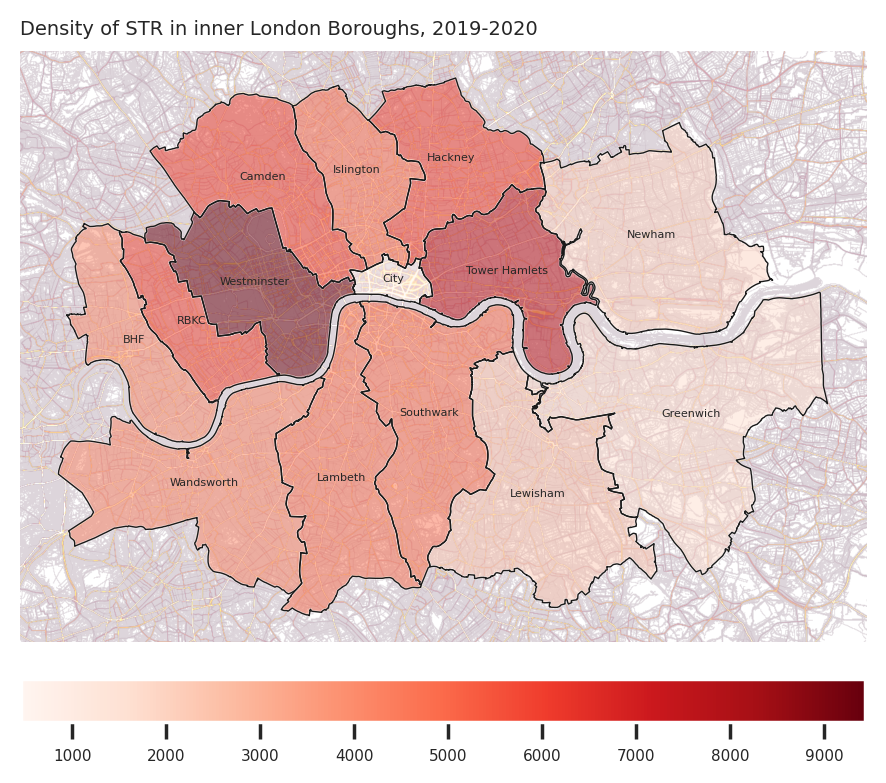

In [ ]:
# BUILD MAP FOR STR BY BOROUGH
# set figure dimensions
plt.figure(figsize=(10, 10))
plt.rcParams['figure.dpi'] = 200
plt.tight_layout()

# LAYER MANAGEMENT
# plot STR frequency
a_freq = filter_data.plot(column="count_list", alpha=0.50, cmap="Reds", legend=True, legend_kwds={'shrink': 0.85, 'orientation': 'horizontal', 'pad': 0.05})
# plot boundary lines for boroughs
boundary = filter_data['geometry'].boundary.plot(ax=a_freq, edgecolor="k", linewidth=0.5)
# add underlying basemap via contextily
cx.add_basemap(a_freq, alpha=0.5, attribution=False, source=cx.providers.Strava.Ride)

# annotate map with borough display names
filter_data.apply(lambda x: boundary.annotate(text=x['D_NAME'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=4), axis=1);

# set axis, figure and show
a_freq.set_axis_off()
a_freq.margins(0)
a_freq.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, labelsize='small')
mtitle = "Density of STR in inner London Boroughs, 2019-2020"
a_freq.set_title(mtitle, fontsize=7, loc='left')

plt.show()

**Preliminary EDA (Histograms I):** We now conduct some preliminary EDA to determine the characteristic data minimums and maximums of each numeric data column. We produce a series of histograms for each numeric data column; in the majority of columns, we observe clear evidence of outlier data that we must account for through cleaning tasks.

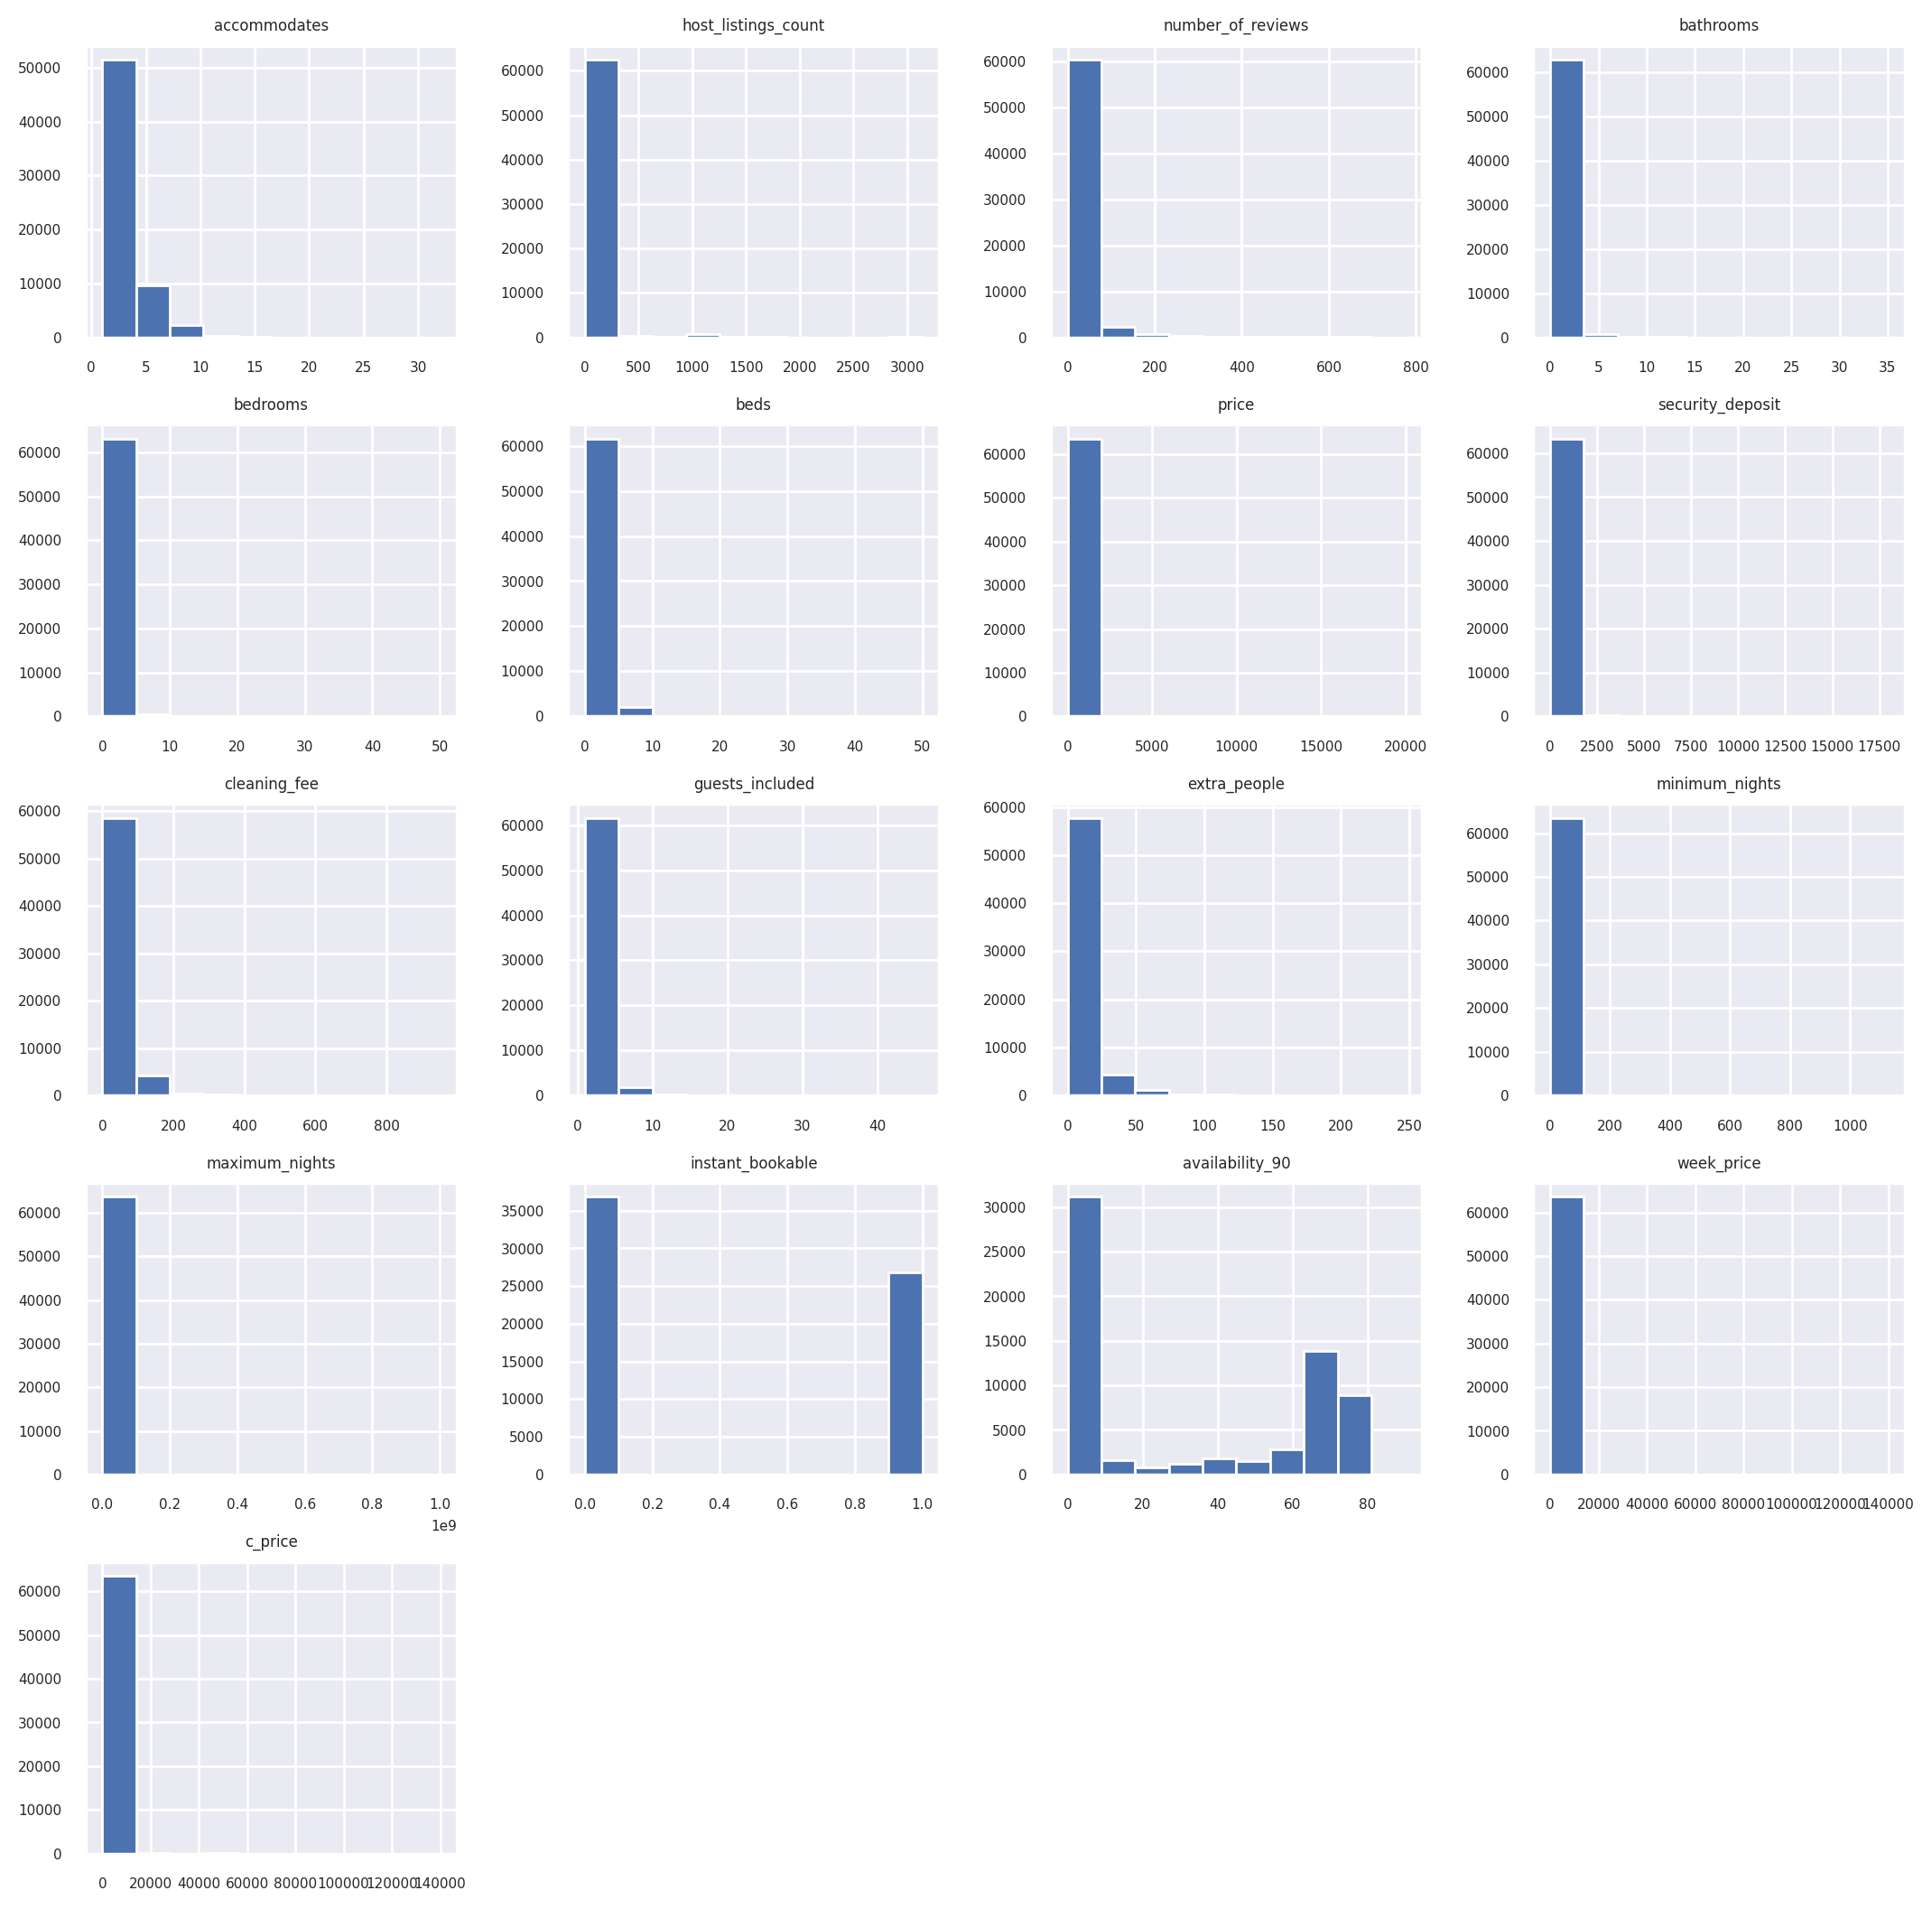

In [ ]:
# plot distribution of numerical cols
f_df.hist(figsize=(13, 13), bins=10)
plt.show()

**Assessing 90-day availability:** While it may initially appear strange that we allow properties with 0 availability over the next 90 days to be included in the dataframe, the parent dataset is drawn from a slice in time from 2020 (and includes properties scraped for the period 2015-2020), so reflects the specific state at time of scraping and not a generalized availability for all time. Thus, we retain this feature with no subsequent modification.

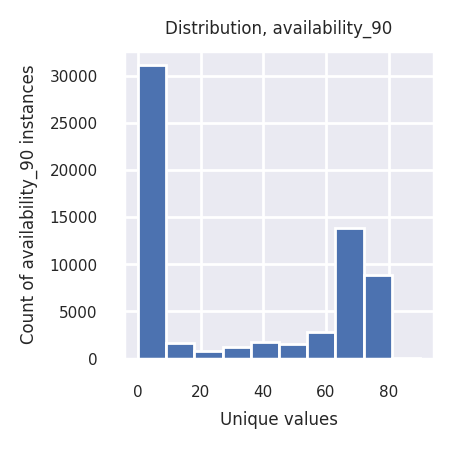

In [ ]:
# plot histogram for distribution visualization
f_df['availability_90'].hist(figsize=(2, 2), bins=10)
plt.title("Distribution, availability_90")
plt.xlabel('Unique values')
plt.ylabel('Count of availability_90 instances')
plt.show()

**Controlling for maximum values across features:** We also approach the outlier issue above by collecting the maximum values for each numeric column in the dataframe. We observe a series of unusual values; for example, we see a maximum value for `minimum_nights` as `1125.0` and for `week_price` as `139790.0`. In some instances, it *may* be possible that properties with some of these features exist in our area of interest, we will ignore them for the purposes of our study.

We control for outliers by pruning those rows that exhibit a `z_score > 3`; this is a measurement that indicates that a value is within three standard deviations of the mean. This causes the number of rows in our dataframe to contract from 63,671 to 51,894.

In [ ]:
# the group histogram suggests presence of outliers, so we get max vals for each numeric column
# function to get max values for specified columns
def get_max_vals(df):
  # get numeric colums only
  num_cols = df.select_dtypes(include='number').columns
  # get the maximum value for each numeric col and store in dictionary
  d_max = {}
  # for each column among num cols, get max and add to dict
  for col in num_cols:
    d_max[col] = df[col].max()
  return d_max

print(get_max_vals(f_df))

{'accommodates': 32.0, 'host_listings_count': 3142.0, 'number_of_reviews': 775.0, 'bathrooms': 35.0, 'bedrooms': 50.0, 'beds': 50.0, 'price': 19970.0, 'security_deposit': 17950.0, 'cleaning_fee': 950.0, 'guests_included': 46.0, 'extra_people': 247.0, 'minimum_nights': 1125.0, 'maximum_nights': 999999999.0, 'instant_bookable': 1.0, 'availability_90': 90.0, 'week_price': 139790.0, 'c_price': 139850.0}


In [ ]:
# calculate z_score and drop above +3 std dev
print("number of rows, pre-drop dataset: ", len(f_df))

# get numeric columns
num_cols = f_df.select_dtypes(include='number').columns
# for each numeric column
for col in num_cols:
  # calculate a z_score for row
  f_df.loc[:, 'z_score'] = abs(zscore(f_df[col]))
  # drop any z_score above 3
  f_df = f_df[f_df['z_score'] <= 3].copy()

print("number of rows, post-drop dataset: ", len(f_df))

number of rows, pre-drop dataset:  63671
number of rows, post-drop dataset:  51294


In [ ]:
# print head as sanity check and drop z_score column, as has filled its purpose
f_df.drop(columns='z_score', inplace=True)
f_df.head(5)

id                 borough      property_type        room_type  \
1   13913               Islington          Apartment     Private room   
2   15400  Kensington and Chelsea          Apartment  Entire home/apt   
4   17506  Hammersmith and Fulham  Bed and breakfast     Private room   
9   36986                 Hackney          Apartment  Entire home/apt   
10  37384               Southwark              House     Private room   

    accommodates  host_listings_count  number_of_reviews  bathrooms  bedrooms  \
1            2.0                  4.0               21.0        1.0       1.0   
2            2.0                  1.0               89.0        1.0       1.0   
4            2.0                  3.0                0.0        1.0       1.0   
9            2.0                  2.0               52.0        1.0       1.0   
10           2.0                  1.0               55.0        1.0       1.0   

    beds  ... cleaning_fee guests_included  extra_people  minimum_nights  \
1    0.0  ...         15.0             1.0          15.0             1.0   
2    1.0  ...         50.0             2.0           0.0            10.0   
4    1.0  ...          0.0             1.0           0.0             3.0   
9    1.0  ...         30.0             1.0           0.0             6.0   
10   1.0  ...          0.0             1.0          10.0             2.0   

    maximum_nights  instant_bookable  availability_90  \
1             29.0               0.0             72.0   
2             50.0               1.0             13.0   
4             21.0               0.0             71.0   
9             21.0               0.0             71.0   
10            21.0               0.0             72.0   

            cancellation_policy  week_price  c_price  
1                      moderate       455.0    570.0  
2   strict_14_with_grace_period       700.0    900.0  
4   strict_14_with_grace_period      1050.0   1050.0  
9   strict_14_with_grace_period       560.0    590.0  
10  strict_14_with_grace_period       490.0    490.0  

[5 rows x 24 columns]

In [ ]:
print(get_max_vals(f_df))

{'accommodates': 9.0, 'host_listings_count': 436.0, 'number_of_reviews': 132.0, 'bathrooms': 2.5, 'bedrooms': 3.0, 'beds': 4.0, 'price': 329.0, 'security_deposit': 850.0, 'cleaning_fee': 129.0, 'guests_included': 4.0, 'extra_people': 47.0, 'minimum_nights': 58.0, 'maximum_nights': 10000000.0, 'instant_bookable': 1.0, 'availability_90': 90.0, 'week_price': 2303.0, 'c_price': 2303.0}


**Preliminary EDA (Histograms II):** We revisit the histogram visualization to see the impact of the preceding outlier review. We observe a notable difference in the overall distribution and maximum `x` value in the majority of our tabular columns. We note in many instances an overrepresentation of a `'0'` value following the `fillna(0)` operation performed on null cells.

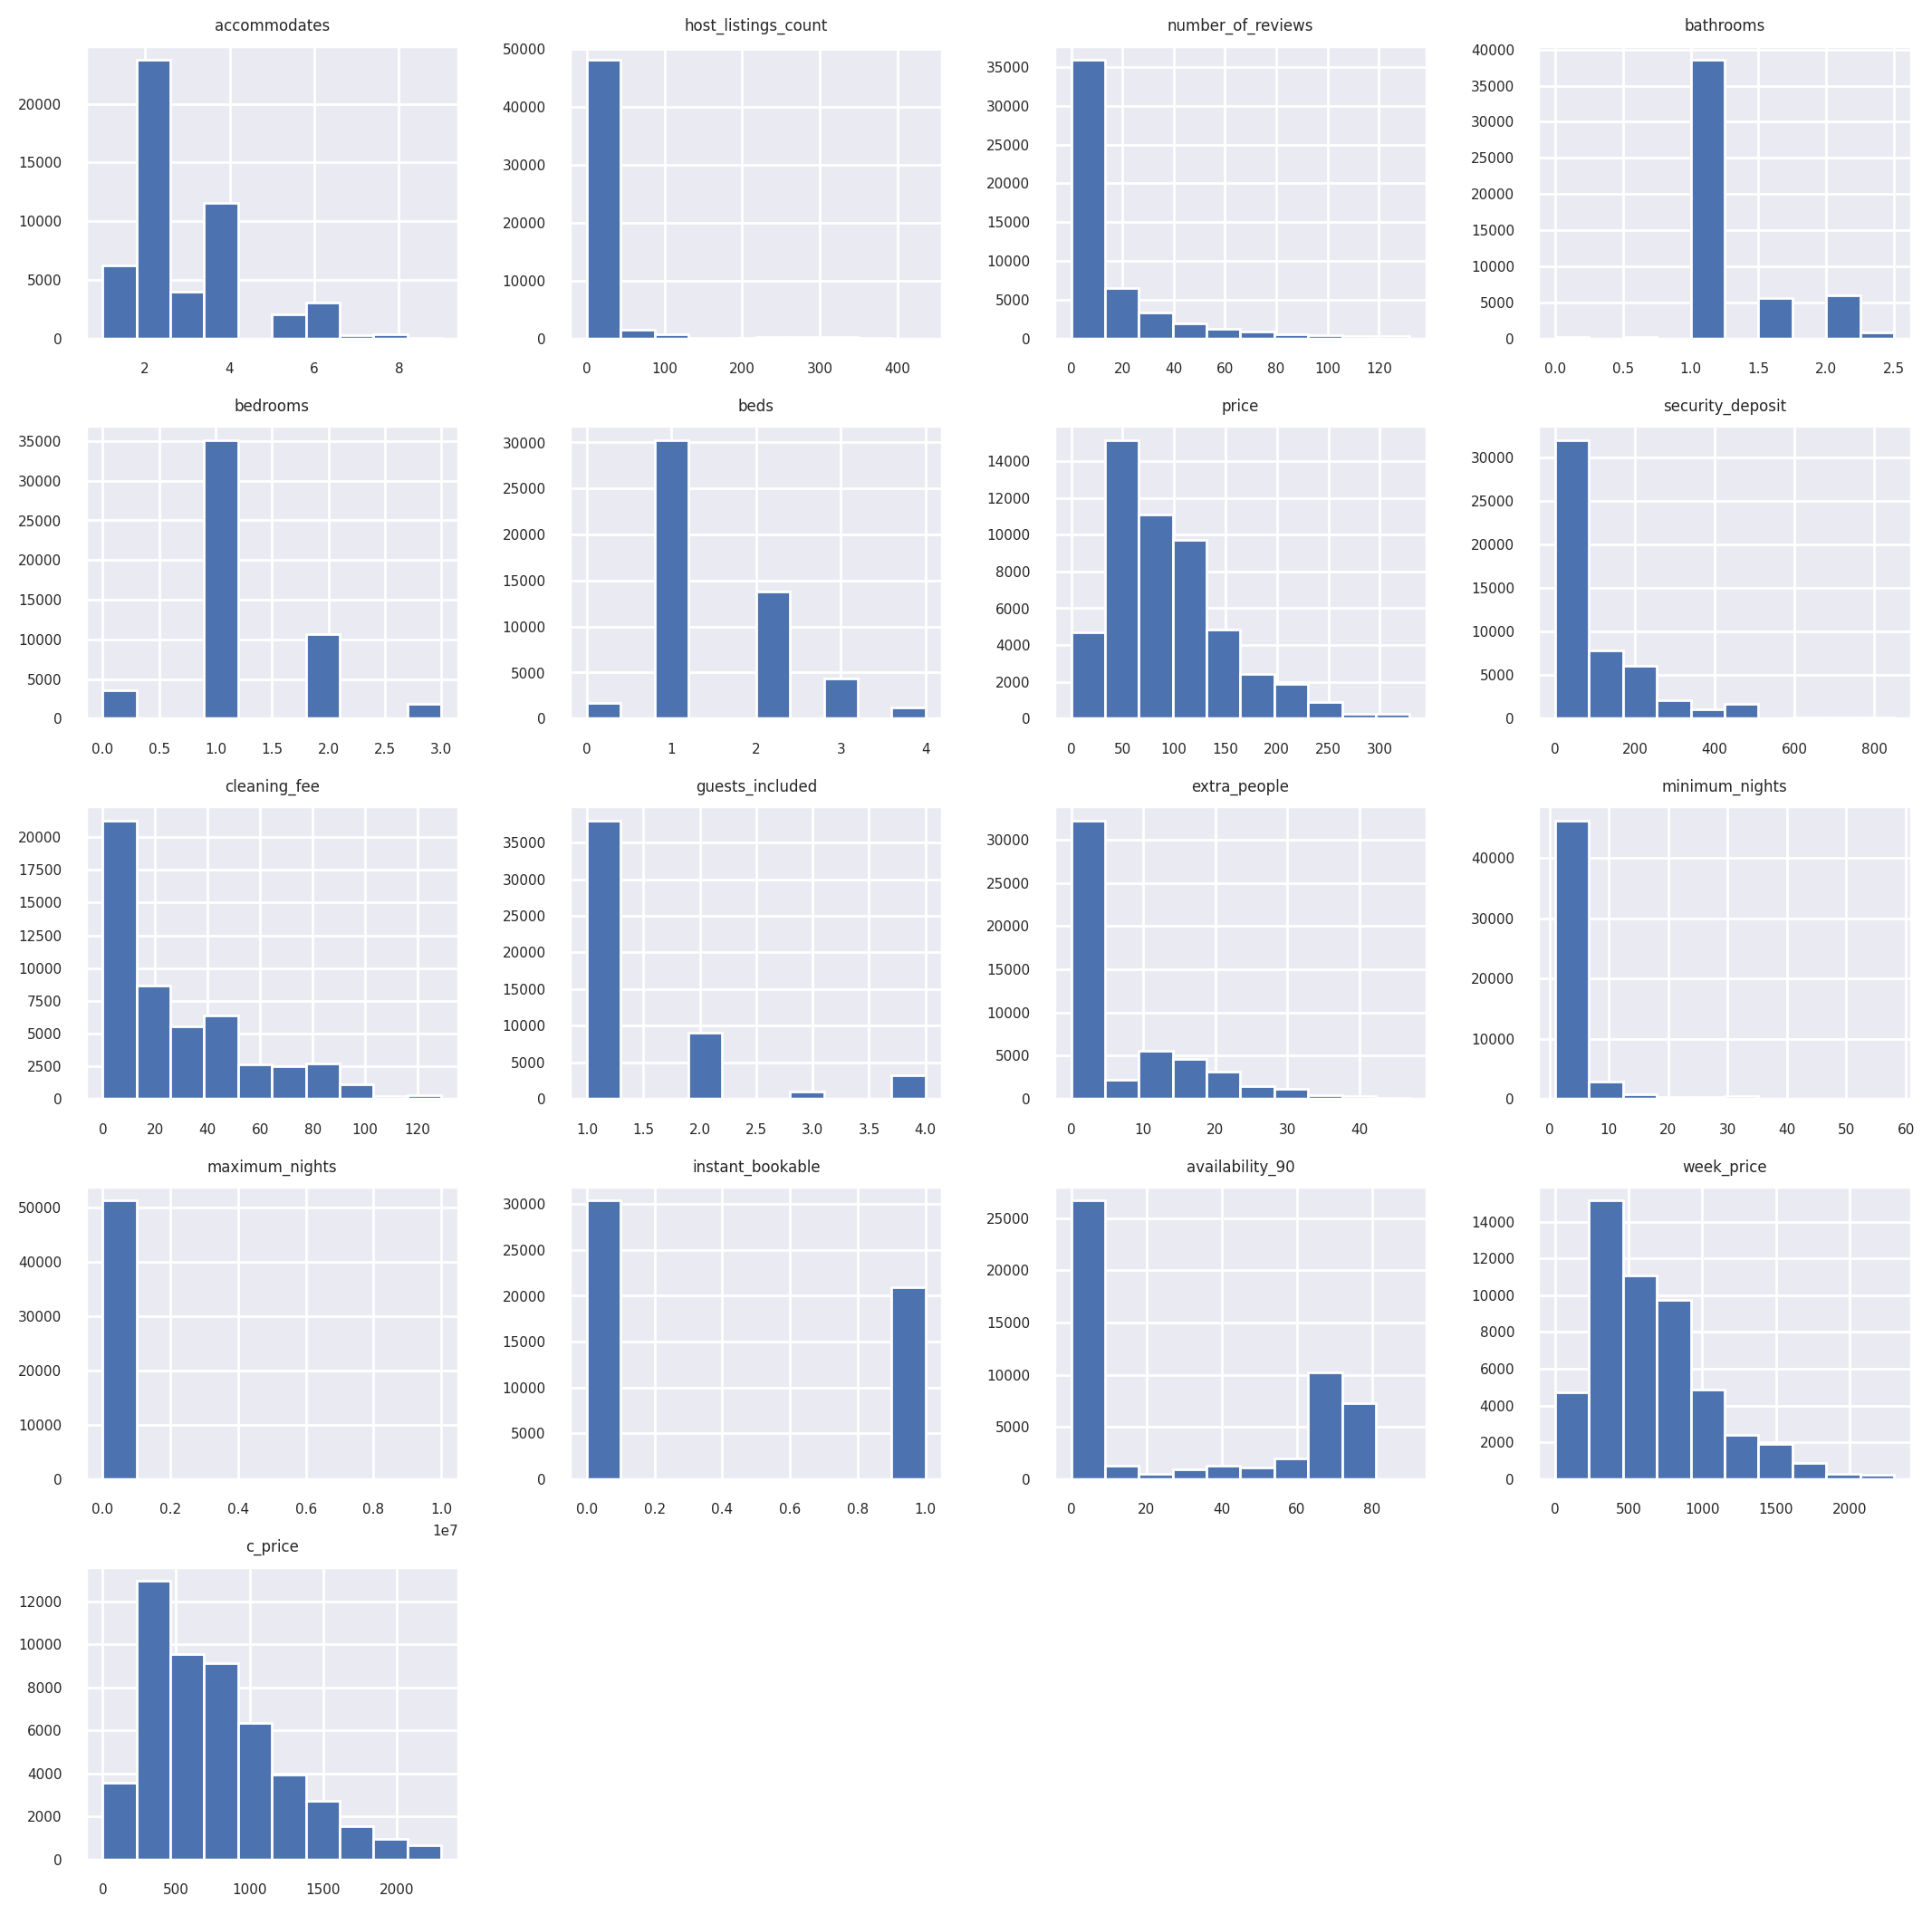

In [ ]:
# plot distribution of numerical cols
f_df.hist(figsize=(13, 13), bins=10)
plt.show()

**Attending to maximum_nights:** We observe that even after we have accounted for outliers, our `maximum_nights` feature remains stubbornly outlying in the histogram. We consider descriptive stats `max`, `min`, and `median` for the feature below. We observe unusual data values such that the maximum number of nights equates to over 27,000 years and the median as 3 years possible stay time. Beginning in 2017, Airbnb imposed a [90-day limit on STR lettings](https://www.theguardian.com/technology/2016/dec/01/airbnb-introduces-90-day-a-year-limit-for-london-hosts) for the region at the behest of the Greater London Assembly. These descriptive statistics would suggest a majority of STR property-owners in inner London have sought and received planning permission from their respective local councils to support long-term rentals, which is unlikely.

In [ ]:
# convert maximum_nights series to list
max_nights = list(f_df['maximum_nights'])
# sort in descending order
max_nights.sort(reverse=True)
# print descriptive stats
f_df['maximum_nights'].describe()

count    5.129400e+04
mean     9.139647e+02
std      4.415855e+04
min      1.000000e+00
25%      3.100000e+01
50%      1.125000e+03
75%      1.125000e+03
max      1.000000e+07
Name: maximum_nights, dtype: float64


Given the above, we will truncate any row instance exceeding a `maximum_nights` value of the prescribed limit to 90.

In [ ]:
# get first 15 rows of maximum_nights to observe for values > 90
f_df['maximum_nights'].head(15)

1       29.0
2       50.0
4       21.0
9       21.0
10      21.0
16       7.0
17      10.0
22     365.0
26      14.0
29      90.0
30      90.0
32       7.0
33      21.0
34      30.0
35    1095.0
Name: maximum_nights, dtype: float64

In [ ]:
# truncate any maximum_nights cell above 90 at 90
f_df['maximum_nights'] = f_df.apply(lambda row: min(row['maximum_nights'], 90), axis=1)
# regenerate descriptive values
f_df['maximum_nights'].describe()

count    51294.000000
mean        69.687819
std         32.298830
min          1.000000
25%         31.000000
50%         90.000000
75%         90.000000
max         90.000000
Name: maximum_nights, dtype: float64

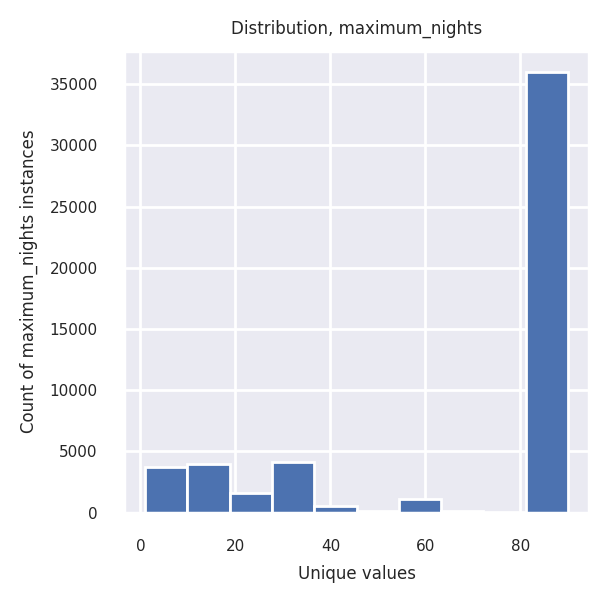

In [ ]:
# plot distribution of maximum_nights to observe change
f_df['maximum_nights'].hist(figsize=(3, 3), bins=10)
plt.title("Distribution, maximum_nights")
plt.xlabel('Unique values')
plt.ylabel('Count of maximum_nights instances')
plt.show()

We observe an overrepresentation of the maximum number of nights possible (90), but have bounded the maximum number to a realistic value.

**Log transformation of select features:** Given the extant skew of some features within the dataset, we apply a logartihmic transformation to reduce the impact of the most extreme values within the feature. We posit this may be useful for the introduction of a multi-layer perceptron during the modelling portion of the work.

Note that in this log transformation, we limit only to the numeric features exhibiting noticeable skew.

In [ ]:
# identify features that will not be logarithmically transformed
no_convert = ["c_price", "week_price", "price", "cleaning_fee", "instant_bookable", "availability_90"]
# from the above features, derive the list of those features that will be transformed
log_convert = [item for item in num_cols if item not in no_convert]
# for each column identified for transformation
for col in log_convert:
  # perform the necessary transformation
  f_df[col] = f_df[col].astype('float64').replace(0.0, 0.01)
  f_df[col] = np.log(f_df[col])

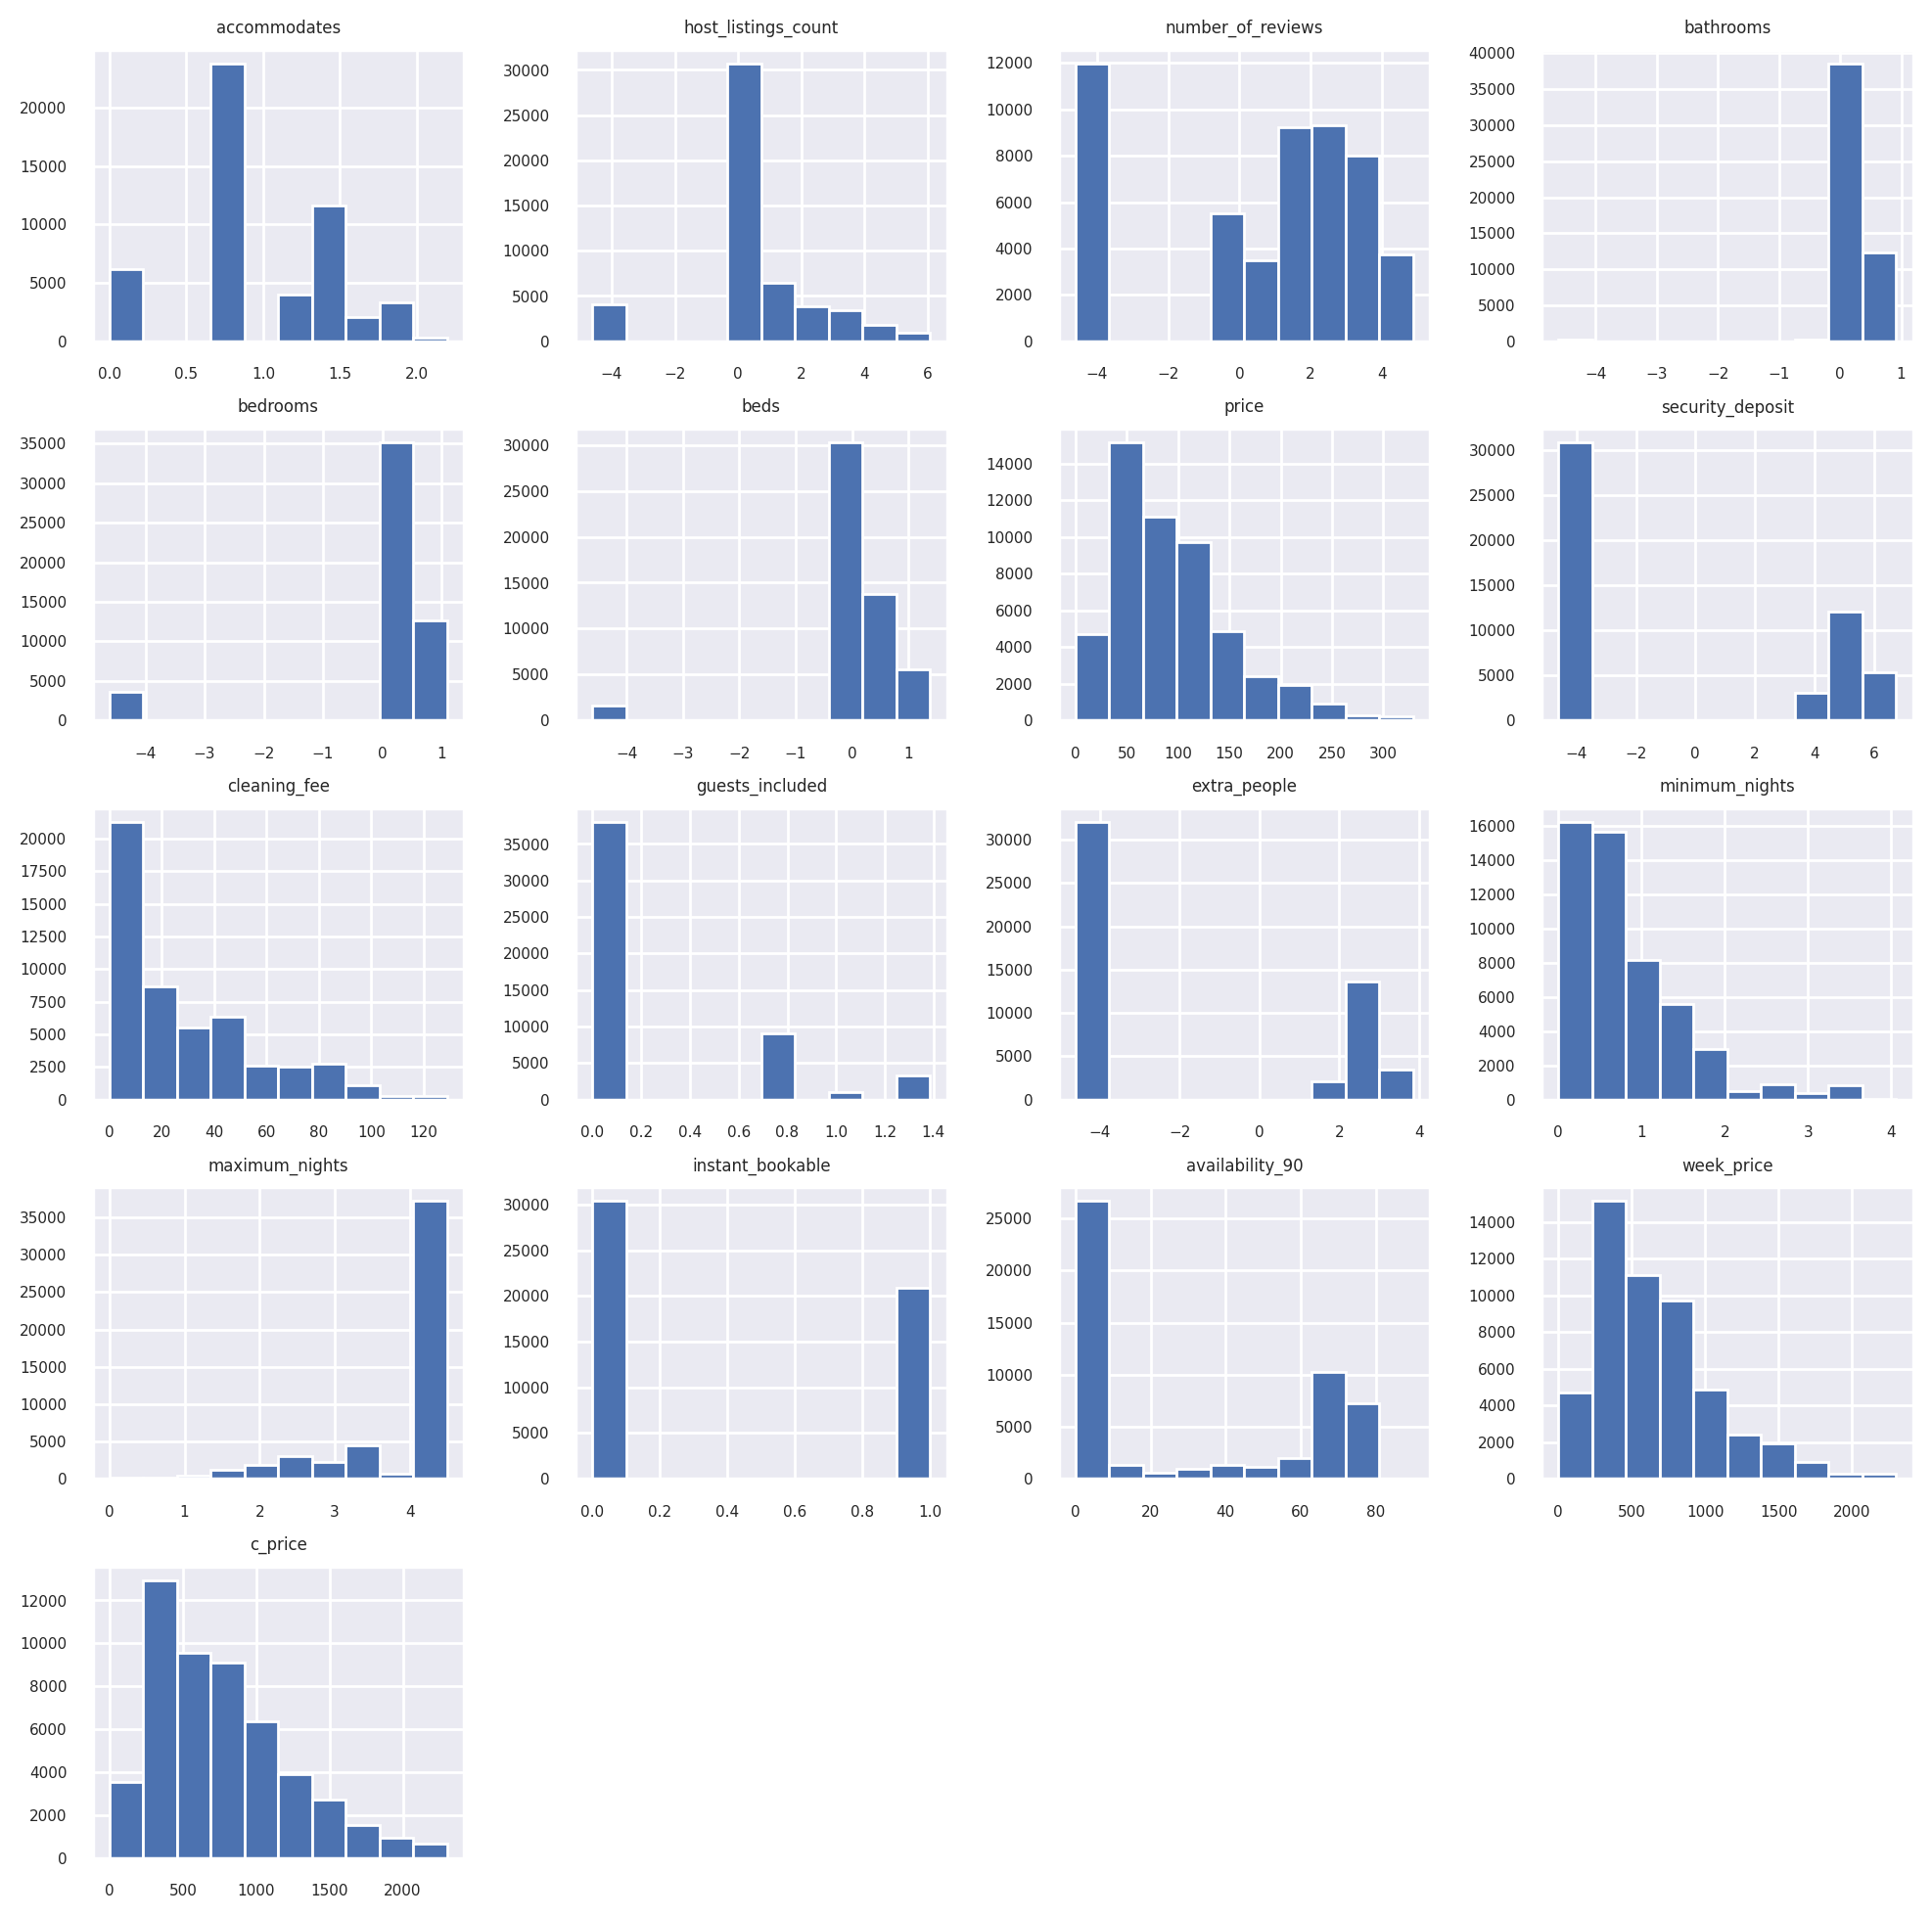

In [ ]:
# plot distribution of numerical cols to evaluate result of transformation
f_df.hist(figsize=(12, 12), bins=10)
plt.show()

**Exploring value counts:** We now use Pandas' `value_counts()` method to output the counts of each unique value associated with several features of interest. Where possible, we will use the count of values as a motivation to simplify our dataframe.

As a demonstration step, we apply `value_counts()` to the `borough` feature, which indicates that most STR properties in the dataframe are found in the inner London boroughs of Westminster, Tower Hamlets, Hackney, and Camden. Conversely, the fewest STR properties are found in the City of London and the boroughs of Greenwich and Newham. This ordering echoes our cartography-based EDA above, with updated values following the columnar drops we have performed.

In [ ]:
f_df.borough.value_counts()

Westminster               6663
Tower Hamlets             6600
Hackney                   5241
Camden                    4645
Kensington and Chelsea    4168
Islington                 4073
Southwark                 3968
Lambeth                   3960
Wandsworth                3365
Hammersmith and Fulham    3165
Lewisham                  2012
Newham                    1634
Greenwich                 1425
City of London             375
Name: borough, dtype: Int64

Within the `property_type` feature, there are several analogous categories that may be collapsed into a more generic label. The below cell uses a dictionary to translate specific to general categories to reduce complexity in the dataframe.

In [ ]:
# genericize housing types to reduce complexity in df
f_df.property_type.replace({
    'Guesthouse': 'Guest suite',
    'Cabin': 'House',
    'Houseboat': 'Boat',
    'Townhouse': 'House',
    'Boutique hotel': 'Hotel',
    'Aparthotel': 'Hotel',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'
    }, inplace=True)

In [ ]:
# see counts of unique values in property type
f_df.property_type.value_counts()

Apartment                        40206
House                             8503
Condominium                       1468
Bed and breakfast                  293
Hotel                              279
Guest suite                        263
Other                              113
Hostel                              72
Boat                                62
Camper/RV                            8
Hut                                  5
Farm stay                            4
Yurt                                 3
Tent                                 3
Barn                                 2
Campsite                             2
Lighthouse                           1
Shepherd's hut (U.K., France)        1
Minsu (Taiwan)                       1
Island                               1
Casa particular (Cuba)               1
Bus                                  1
Parking Space                        1
Castle                               1
Name: property_type, dtype: Int64

Given the above output, we observe a tail of property types that are not germane to our analysis - whether because they do not make contextual sense in London (i.e. Minsu, casa particular) or because they are too small in number to be meaningful. We will thus drop any property type with a count fewer than 10, as is done in the column below.

In [ ]:
# convert to dictionary
d_ptype_count = dict(f_df.property_type.value_counts())
# identify elements to retain in df
retain_ptype = [key for key, value in d_ptype_count.items() if value > 10]
# drop any rows with items not in retain list
f_df = f_df[f_df['property_type'].isin(retain_ptype)]
print(f_df.property_type.value_counts())
print("number of rows, post-drop dataset: ", len(f_df))

Apartment            40206
House                 8503
Condominium           1468
Bed and breakfast      293
Hotel                  279
Guest suite            263
Other                  113
Hostel                  72
Boat                    62
Name: property_type, dtype: Int64
number of rows, post-drop dataset:  51259


For visualization purposes, we plot the **distribution of STR property types in inner London**. Note that we are interested in *relative proportion* so we use a logarithmic scale to array the data as a horizontal bar graph.

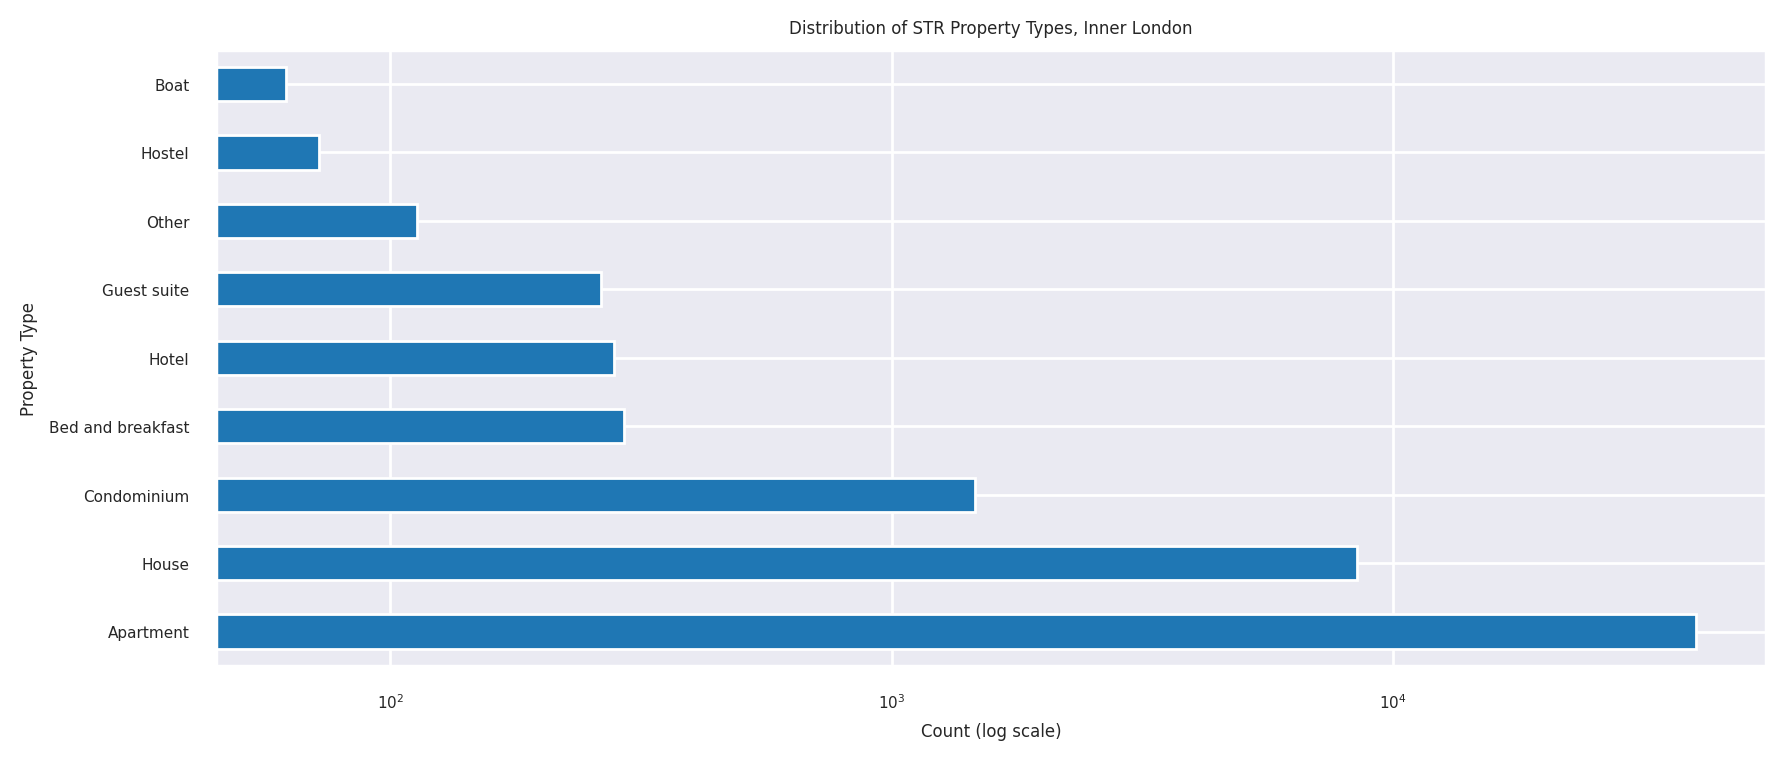

In [ ]:
# set figure size of plot
plt.figure(figsize=(10, 4))
# get the property value counts
property_counts = f_df['property_type'].value_counts()
# plot a horizontal bar graph on property_counts
property_counts.plot(kind='barh', color="#1f77b4")
# set scale and text, then show
plt.xscale('log')
plt.xlabel('Count (log scale)')
plt.ylabel('Property Type')
plt.title('Distribution of STR Property Types, Inner London')
plt.show()

We perform the same value counting operation on the feature `room_type` to determine whether any category should be eliminated. We do not observe any major outliers, and so no modification is required.

In [ ]:
# see counts of unique room_type values, retain
f_df.room_type.value_counts()

Entire home/apt    28874
Private room       21665
Hotel room           404
Shared room          316
Name: room_type, dtype: Int64

As above, we apply `value_counts()` method to the feature `bed_type`. We observe that we may derive a binary categoriation of "real bed", "not real bed" to reduce complexity. In the following cell, we use a dictionary to genericize the bed types to a numeric value, where `Real Bed = 1` and `not Real Bed = 0`. We observe this simplifies the dataframe by aggregating a number of small values into one larger value. We reason the binary is functional as individuals are likely to weight a `Real Bed` with greater preference than any other type.

In [ ]:
# see counts of unique bed_type values, retain
f_df.bed_type.value_counts()

Real Bed         50856
Pull-out Sofa      234
Futon              105
Couch               41
Airbed              23
Name: bed_type, dtype: Int64

In [ ]:
# genericize bed types (from -> to)
f_df.bed_type.replace({
    'Real Bed': 'Bed',
    'Pull-out Sofa': 'Other',
    'Futon': 'Other',
    'Couch': 'Other',
    'Airbed': 'Other'
    }, inplace=True)
# modify bed type as copy
bed_type_mod = f_df['bed_type'].copy().map({'Bed': 1, 'Other': 0})
# update bed type to modified series
f_df['bed_type'] = bed_type_mod
# print value counts as sanity check
f_df.bed_type.value_counts()

1    50856
0      403
Name: bed_type, dtype: int64

In [ ]:
# preview effect of change on limited number cells
print(f_df['bed_type'].head(5))

1     1
2     1
4     1
9     1
10    1
Name: bed_type, dtype: int64


We perform the same value counting operation on the feature `cancellation_policy` to determine whether any category should be eliminated. As these categories are defined by the Airbnb platform rules, we preserve as they are.

In [ ]:
# see counts of unique cancellation_policy values, retain
f_df.cancellation_policy.value_counts()

strict_14_with_grace_period    20184
flexible                       17340
moderate                       13468
super_strict_30                  150
super_strict_60                  111
strict                             6
Name: cancellation_policy, dtype: Int64

We now investigate the `amenities` feature and observe the existence of a quasi-list format; that is, a `string` of comma-separated values. Each amenity value is ostensibly distinct, but we reason we can split each list string into its constituent parts and derive more meaning from the resulting data. This will be a forthcoming data cleaning task under the header **Parsing amenities**.

In [ ]:
# preview amenities series
print(f_df['amenities'].head(5))

1     {TV,"Cable TV",Wifi,Kitchen,"Paid parking off ...
2     {TV,"Cable TV",Internet,Wifi,"Air conditioning...
4     {TV,Internet,Wifi,"Air conditioning",Breakfast...
9     {TV,"Cable TV",Internet,Wifi,Kitchen,Breakfast...
10    {TV,"Cable TV",Internet,Wifi,"Paid parking off...
Name: amenities, dtype: string


In [ ]:
# observe number of amenities: we reason that there are fewer groupings of
# amenities, they may just be arrayed in different order
f_df['amenities'].nunique()

46130

In [ ]:
# will develop function to handle this column, as data is dispersed and uncleaned
f_df.amenities.value_counts()

{}                                                   168
{TV,Wifi,Kitchen,Heating,Washer,Dryer,"Smoke a...     43
{TV,Wifi,Kitchen,Heating,Washer,"Smoke alarm",...     25
{TV,"Cable TV",Wifi,Kitchen,Heating,Washer,Dry...     24
{TV,Wifi,Kitchen,Heating,Washer,"Smoke alarm",...     22
                                                    ... 
{Kitchen,Heating,Washer,"Smoke alarm",Essentia...      1
{TV,"Air conditioning",Kitchen,Heating,Washer,...      1
{TV,"Cable TV",Internet,Wifi,"Wheelchair acces...      1
{TV,Wifi,Kitchen,"Free parking on premises",He...      1
{TV,Wifi,Kitchen,Heating,Washer,"Smoke alarm",...      1
Name: amenities, Length: 46130, dtype: Int64

In this cell, we ready our dataframe for use in correlation matrices by splitting the numeric and categorical features into distinct dataframes `nums_df` and `strs_df`, respectively. We perform some additional casting operations as a sanity check.

In [ ]:
# identify string columns as list
cols_str = ['borough', 'property_type', 'room_type', 'amenities', 'cancellation_policy']
# identify columns to drop (for correlation) as list
cols_drop = ['price', 'security_deposit', 'cleaning_fee', 'extra_people', 'week_price']
# identify numeric columns as list
cols_num = [item for item in list(f_df.columns) if item not in cols_str and item not in cols_drop]

# for each string column, cast explicitly as string from object
for col in cols_str:
  f_df[col] = f_df[col].astype("string")

# for each col in cols num, explicitly cast as float
for col in cols_num:
    f_df[col] = f_df[col].astype(float)

# confirm dtypes optically
print(f_df.dtypes)

# generate dataframes from derived lists for numeric and string data
nums_df = f_df[cols_num]
strs_df = f_df[cols_str]

id                     float64
borough                 string
property_type           string
room_type               string
accommodates           float64
host_listings_count    float64
number_of_reviews      float64
bathrooms              float64
bedrooms               float64
beds                   float64
bed_type               float64
amenities               string
price                  float64
security_deposit       float64
cleaning_fee           float64
guests_included        float64
extra_people           float64
minimum_nights         float64
maximum_nights         float64
instant_bookable       float64
availability_90        float64
cancellation_policy     string
week_price             float64
c_price                float64
dtype: object


**Preliminary EDA (Correlation Matrix I):** We now consider a correlation matrix heat map to determine if we may observe some emerging correlations in the data. The matrix reveals some intuitive conclusions (for instance, the number of people that may be accommodated by an STR property exhibits positive correlation to the cumulative price, to the number of beds, and to the number of guests).

We may now drop some additional feature columns, including those that are not predictive by definition (`id`) and those that exhibit limited correlation to the `c_price` column (i.e. values between -0.1 and 0.1)

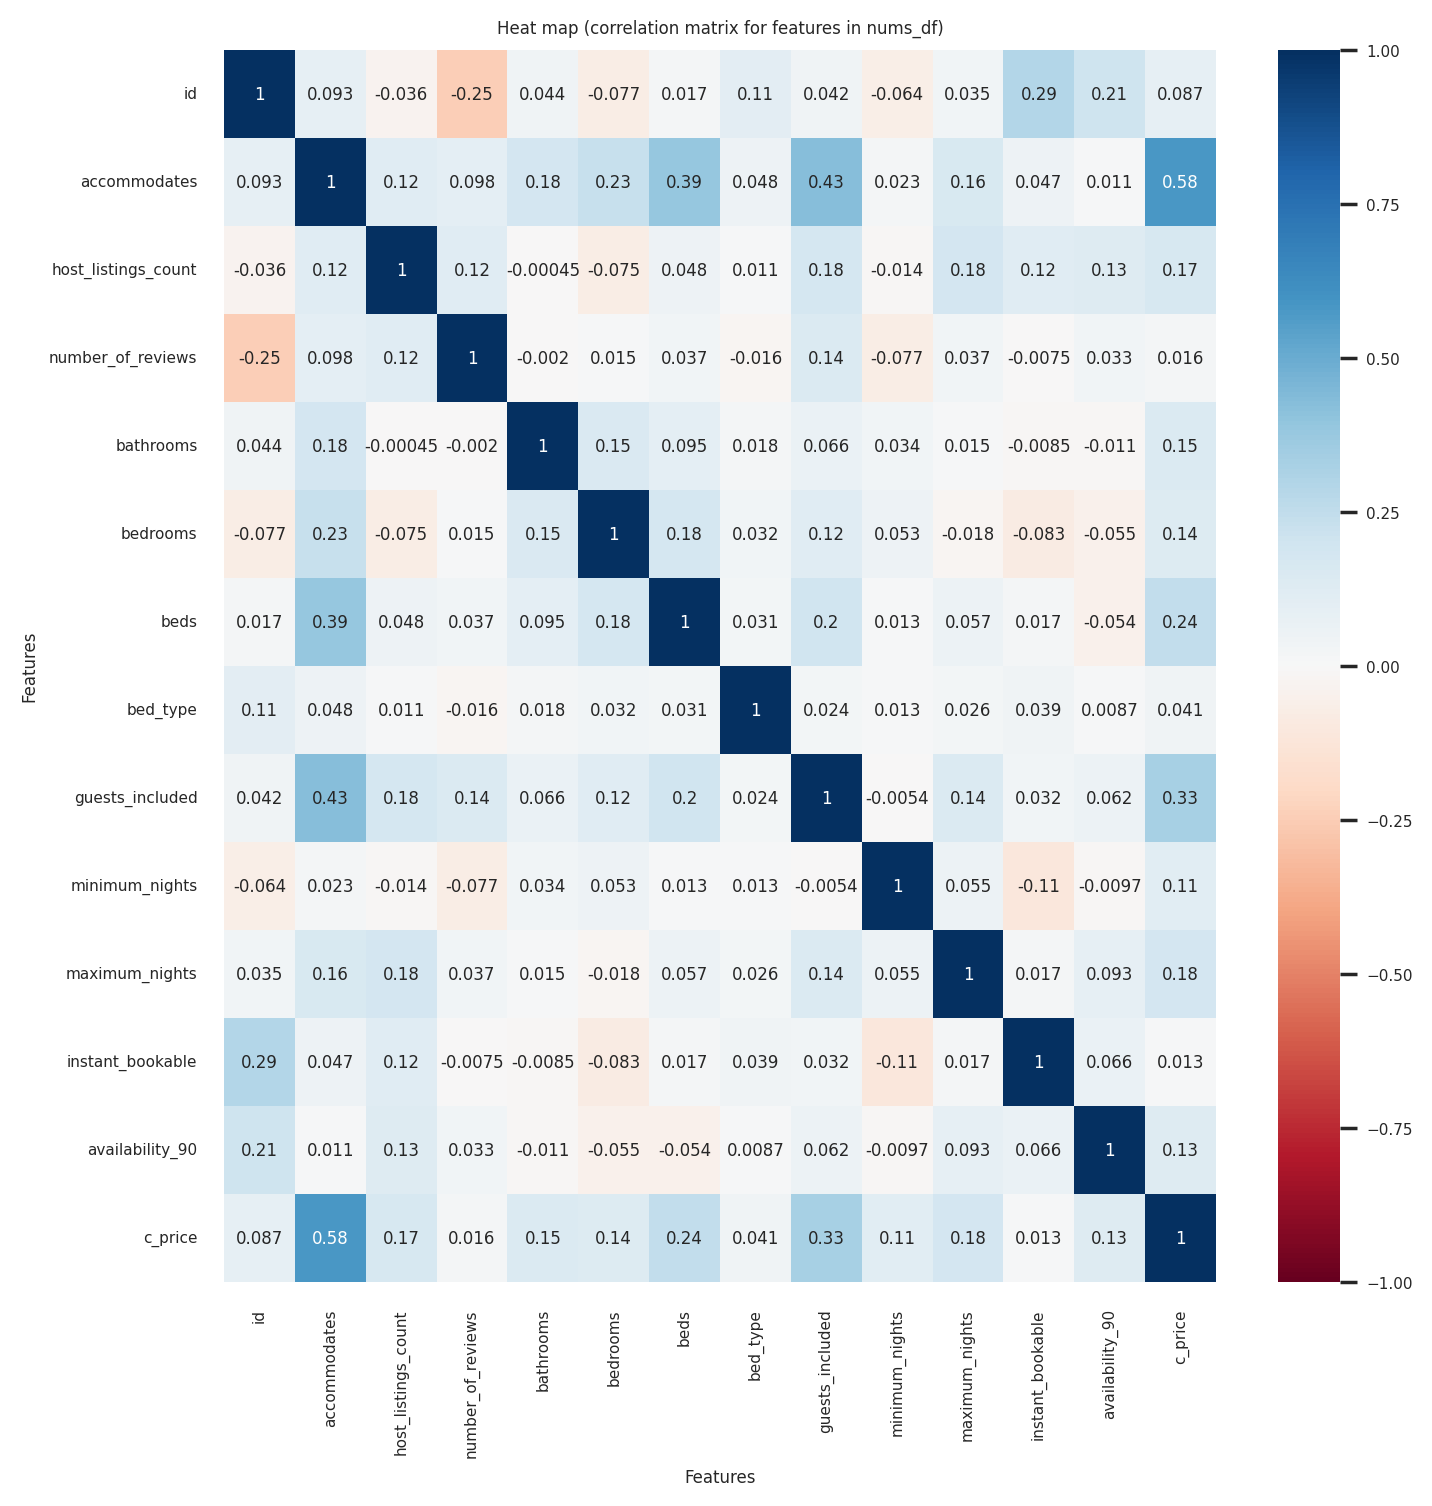

In [ ]:
# generate correlation matrix
corr_mat_1 = nums_df.corr(numeric_only=True)
# plot figure size to spec
plt.figure(figsize=(8,8))
# generate heat map from corr_mat with spec colour map and standard colour scale
hmap = sns.heatmap(data=corr_mat_1, cmap="RdBu", vmin=-1, vmax=1, annot=True)
# set labels and title
title = "Heat map (correlation matrix for features in nums_df)"
hmap.set(xlabel="Features", ylabel="Features", title=title)
title = "Heat map (correlation matrix for features in nums_df)"
# show plot
plt.show()

In [ ]:
# identify columns to drop based on criteria explained in above text and corr matrix
to_drop = ['id', 'number_of_reviews', 'bed_type', 'instant_bookable']
# identify columns to retain using list comprehension
to_retain = [col for col in f_df.columns if col not in to_drop]
# recompose dataframe based on retained columns
f_df = f_df[to_retain].copy()

**Parsing amenities:** The amenities listed for each STR property in the dataframe exist in a list-as-string comma-separated format:
```
{TV,"Cable TV",Internet,Wifi,Kitchen,"Paid parking off premises","Buzzer/wireless intercom",Heating,"Smoke alarm"}
```
We observe that some, but not all, amenities are enclosed in quotation marks and the string is opened and closed with a brace as `{}`. We will write functions to parse amenity strings, build them as Python lists, and count the unique occurrences of each amenity across the whole dataframe as a means to assist our composition of the dataframe. This is performed using three functions:

* `parse_amens(string)`: Function parses a string representation of the listed amenities for each STR property, as defined above.
* `add_amens(l, d)`: Function adds parsed amenities from a list `l` to a pre-existing dictionary `d`; counts the number of amenity instances at each addition.
* `build_dict_amenities(df)`: Given a dataframe `df`, function uses `parse_amens()` and `add_amens()` to build a sorted dictionary of cumulative amenity instances and their counts.

We then visualize the amenities (in abstract, as we do not as yet care about the unique amenity values themselves) and their counts to understand their potential impact on the forthcoming analysis.


In [ ]:
# function to parse a string representation of listed amenities
def parse_amens(string):
  # strip bracketing chars
  string = string.strip("{}")
  # split string on comma separator, return list
  amens = string.split(",")
  # replace superfluous chars and set to lowercase as list
  amens = [item.replace('"', '').replace(' ', '_').lower() for item in amens]
  # return list, dropping any none vals
  return list(filter(None, amens))

# function to add amenities from list l to dict d
# (total count of amenities in listings dataset)
def add_amens(l, d):
  # for each amenity in list
  for item in l:
    # increment count of cumulative amenities in dictionary
    d[item] = d.get(item, 0) + 1
  return d

# function builds a dictionary of cumulative amenities from dataframe
def build_dict_amenities(df):
  d = {}
  # apply function to dataframe to integrate parsed amenities to dict
  df.apply(lambda x: add_amens(parse_amens(x['amenities']), d), axis=1)
  # drop error vals from dict
  d = {k: v for k, v in d.items() if "translation_missing" not in k}
  # sort the dictionary by value (list) and return as dict
  sort_d = sorted(d.items(), key=lambda x:x[1], reverse=True)
  sort_d = dict(sort_d)
  # return dictionary of amenity instances
  return sort_d

# get cumulative sorted dictionary
d_amens = build_dict_amenities(f_df)
# convert to df so that we can easily display amenities, count
df_amens = pd.DataFrame(list(d_amens.items()), columns=['amenity', 'count'])
df_amens.head(len(df_amens))

amenity  count
0                      wifi  49206
1                   heating  48291
2                essentials  47976
3                   kitchen  47455
4               smoke_alarm  44299
..                      ...    ...
182            private_pool      1
183           mountain_view      1
184              beach_view      1
185            mobile_hoist      1
186  electric_profiling_bed      1

[187 rows x 2 columns]

**Evaluating amenities:** Given the below visualization `Count of amenities`, we observe the existence of many unique amenities on the right-hand side that barely register given the amenities approaching the highest count on the left-hand side of the x-axis.

We now consider how we can refine this list further; we posit that we should drop both the amenities that occur so frequently as to be expected in an STR property (that is, their presence will not sway people *towards* staying at a property) and those that occur so little that they are not an indication of any particular demand.

We begin by printing the amenity and its respective count from dictionary `d_amens`. We continue to drop any amenity that occurs more than ~75% of the time and those that occur less than ~5% of the time. This will again support our goal to reduce the complexity of the dataframe.

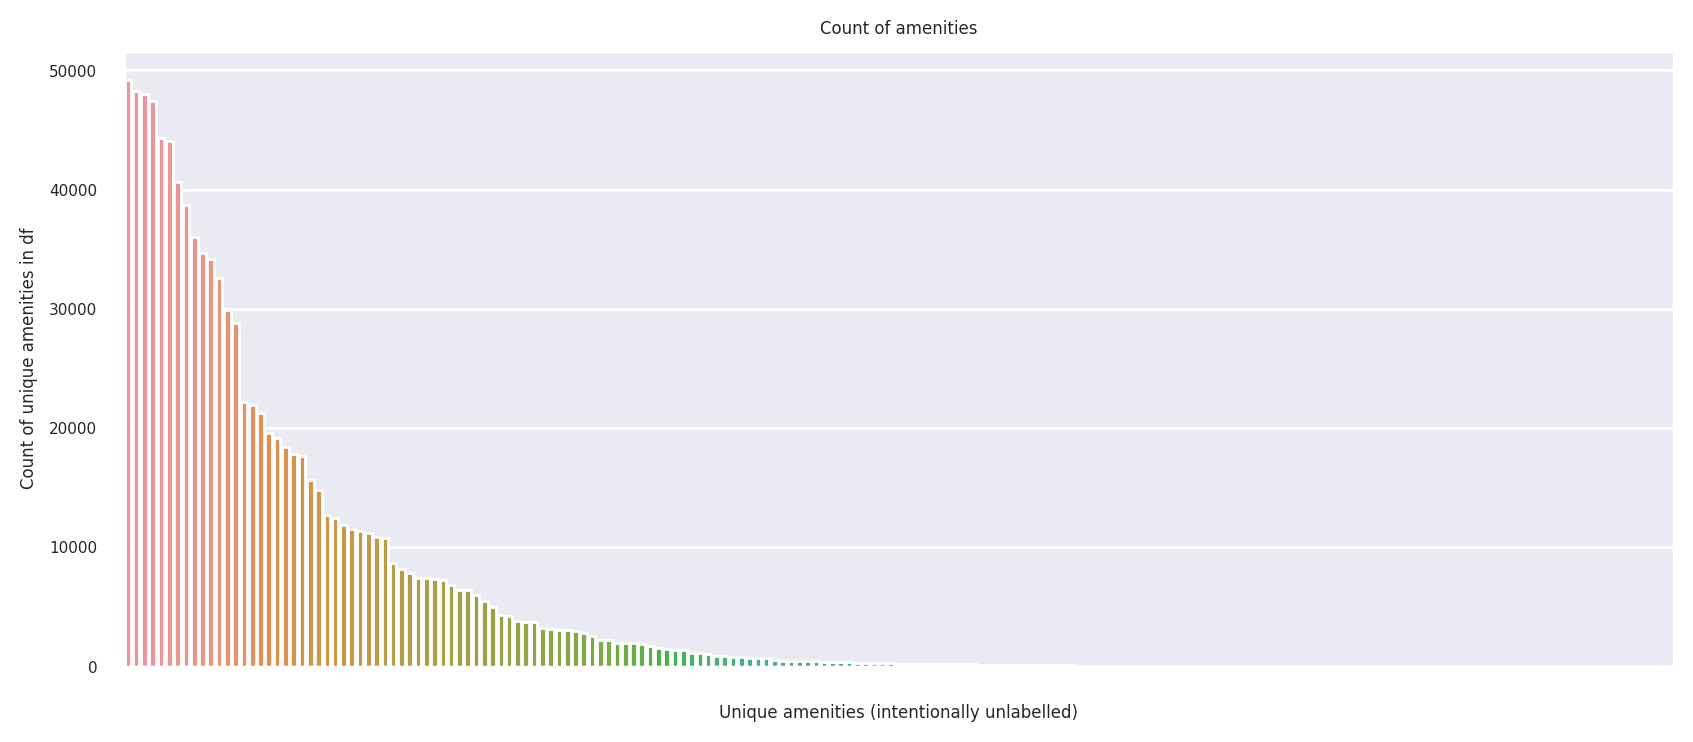

In [ ]:
# visualization for threshold setting of amenities to include
# set figure size
plt.figure(figsize=(10, 4))
# plot using seaborn
bplot = sns.barplot(x=df_amens['amenity'], y=df_amens['count'])
# set formatting and show
bplot.set(xticklabels=[])
plt.title('Count of amenities')
plt.xlabel('Unique amenities (intentionally unlabelled)')
plt.ylabel('Count of unique amenities in df')
plt.show()

For a moment, we zoom in on the top 20 amenities among STRs in inner London. We observe the most frequent-and thus, most general-are wireless internet, heating, an all-encompassing 'essentials' item, and a kitchen. As noted, these-and the lowest-occurring items-will be dropped as they will not meaningfully contribute to our discussion.

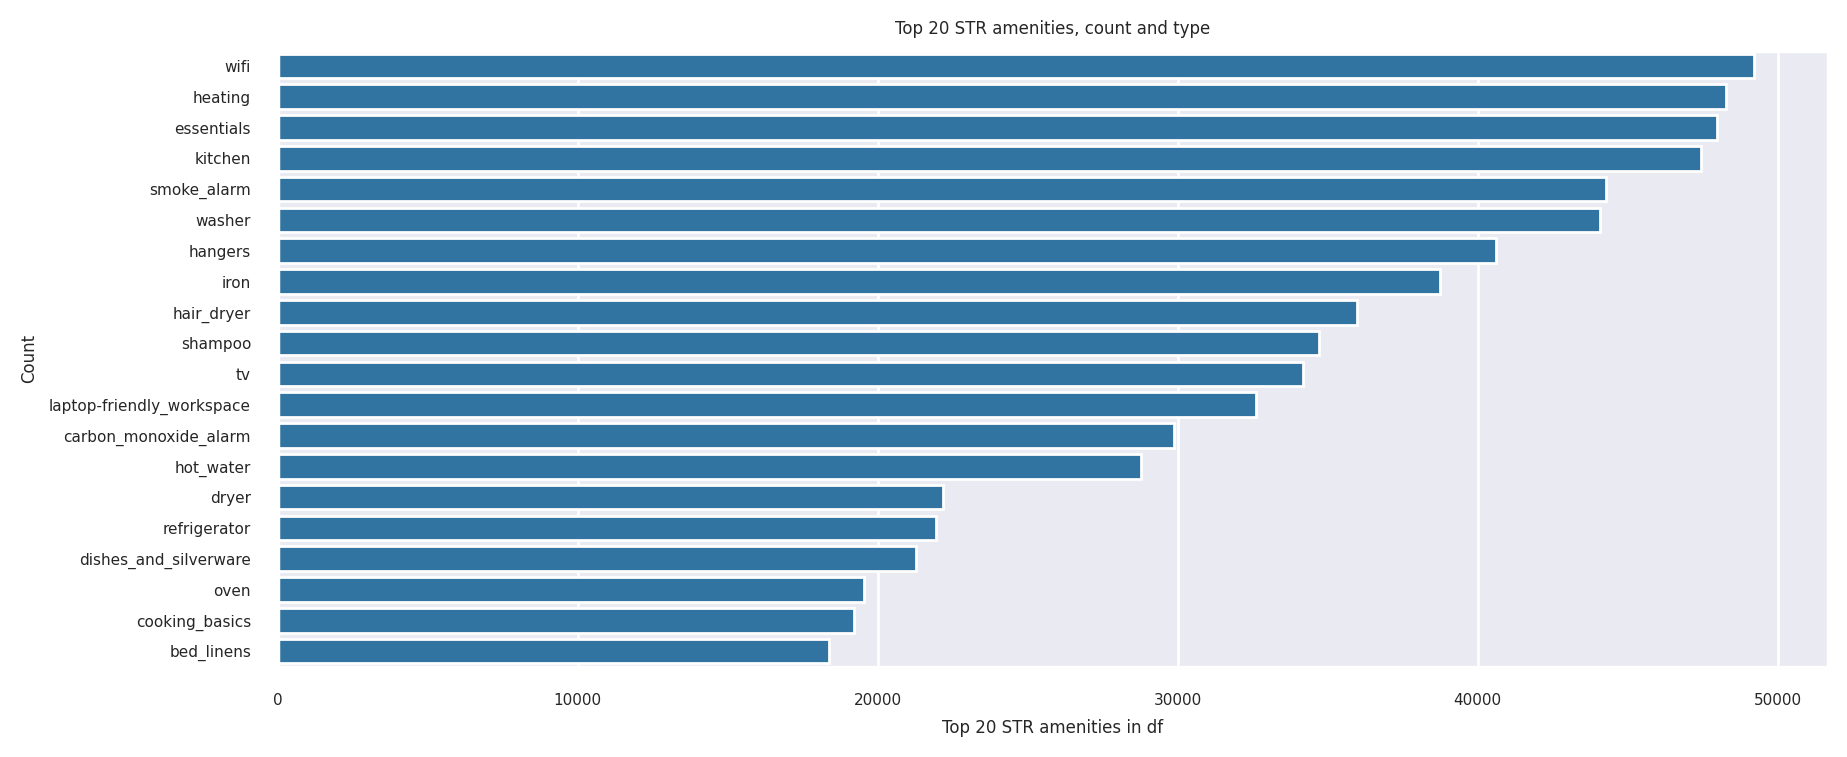

In [ ]:
# visualization for threshold setting of amenities to include
# set figure size
plt.figure(figsize=(10, 4))
# plot using seaborn
bplot = sns.barplot(y=df_amens['amenity'].head(20), x=df_amens['count'].head(20), color="#1f77b4")
# set formatting and show
plt.title('Top 20 STR amenities, count and type')
plt.xlabel('Top 20 STR amenities in df')
plt.ylabel('Count')
plt.show()

In [ ]:
# drop items that exist in most STR, and those that exist in very few STR
df_amens = df_amens[(df_amens['count'] < 40000) & (df_amens['count'] > 1500)].copy().reset_index()
df_amens.head(len(df_amens))

index                     amenity  count
0       7                        iron  38735
1       8                  hair_dryer  35988
2       9                     shampoo  34721
3      10                          tv  34187
4      11   laptop-friendly_workspace  32612
5      12       carbon_monoxide_alarm  29881
6      13                   hot_water  28775
7      14                       dryer  22180
8      15                refrigerator  21960
9      16       dishes_and_silverware  21275
10     17                        oven  19558
11     18              cooking_basics  19203
12     19                  bed_linens  18387
13     20                   microwave  17797
14     21                       stove  17631
15     22           fire_extinguisher  15681
16     23               first_aid_kit  14783
17     24                    elevator  12681
18     25         family/kid_friendly  12479
19     26            private_entrance  11866
20     27                  dishwasher  11564
21     28                coffee_maker  11370
22     29                    internet  11230
23     30        lock_on_bedroom_door  10832
24     31     long_term_stays_allowed  10758
25     32  extra_pillows_and_blankets   8670
26     33             host_greets_you   8188
27     34               self_check-in   7877
28     35         private_living_room   7424
29     36     luggage_dropoff_allowed   7384
30     37                    cable_tv   7379
31     38   paid_parking_off_premises   7240
32     39            patio_or_balcony   6858
33     40    buzzer/wireless_intercom   6407
34     41    free_parking_on_premises   6377
35     42                   breakfast   5965
36     43                     lockbox   5529
37     44          garden_or_backyard   5031
38     45                     bathtub   4324
39     46             smoking_allowed   4243
40     47                pets_allowed   3806
41     48                 safety_card   3766
42     49         free_street_parking   3720
43     50            24-hour_check-in   3255
44     51           single_level_home   3177
45     52            indoor_fireplace   3058
46     53            air_conditioning   3052
47     54                  shower_gel   3006
48     55                   trash_can   2800
49     56                       other   2580
50     57                  high_chair   2217
51     58    paid_parking_on_premises   2206
52     59    pack_’n_play/travel_crib   2004
53     60                     hot_tub   1982
54     61                        crib   1958
55     62         ethernet_connection   1868
56     63                         gym   1690
57     64       room-darkening_shades   1514

We visualize the `Count of filtered amenities` to observe a more manageable set of amenities that still exhibit some clear leading values but is not so unbalanced as to be useless to our understanding.

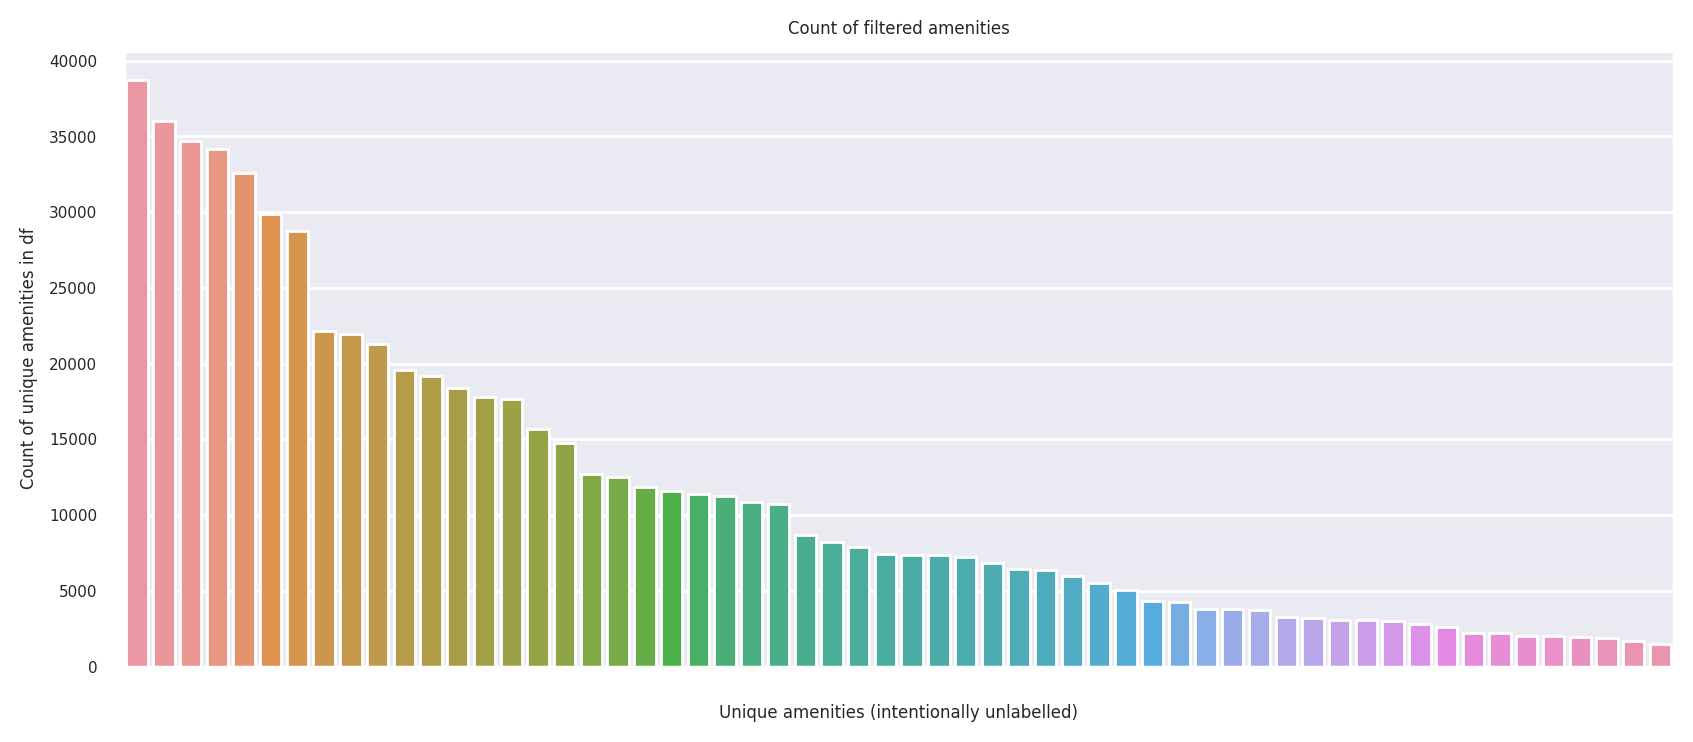

In [ ]:
# visualization for threshold setting of amenities to include
# set figure size
plt.figure(figsize=(10, 4))
# plot using seaborn
bplot = sns.barplot(x=df_amens['amenity'], y=df_amens['count'])
# set formatting and show
bplot.set(xticklabels=[])
plt.title('Count of filtered amenities')
plt.xlabel('Unique amenities (intentionally unlabelled)')
plt.ylabel('Count of unique amenities in df')
plt.show()

**Integrating amenities:** With a consolidated list of cumulative amenities, we now perform a manual one-hot encoding of amenity features. For each amenity included in the filtered dictionary `d_amens_f`, we add a column to a copy dataframe `am_df` ('amenities dataframe') indicating whether the corresponding row has `(1)` or does not have `(0)` the specified amenity. This is performed in two steps:

*   First, for each key (column) in `d_amens_f`, we set the corresponding `am_df[key] = 0`
*   Second, for each amenity associated with a row entry (STR property), we set the corresponding columnar cell to `1`

We then perform minor visual testing to ensure these operations were performed as anticipated.

In [ ]:
# create a new dataframe for amenity boolean columns
am_df = f_df.copy()
# for each amenity (key) in dictionary of amenities
a_cols = df_amens['amenity'].tolist()
for col in a_cols:
  # instantiate value to 0 as default
  am_df[col] = 0
print(am_df.dtypes)

borough                        string
property_type                  string
room_type                      string
accommodates                  float64
host_listings_count           float64
bathrooms                     float64
bedrooms                      float64
beds                          float64
amenities                      string
price                         float64
security_deposit              float64
cleaning_fee                  float64
guests_included               float64
extra_people                  float64
minimum_nights                float64
maximum_nights                float64
availability_90               float64
cancellation_policy            string
week_price                    float64
c_price                       float64
iron                            int64
hair_dryer                      int64
shampoo                         int64
tv                              int64
laptop-friendly_workspace       int64
carbon_monoxide_alarm           int64
hot_water   

In [ ]:
# function adds amenities to df – any amenity associated with row is added
# to associated column
def add_amenities_to_df(cols, df_row):
  # get amenities for row as list
  amenities = parse_amens(df_row['amenities'])
  # for each amenity in list of amenities
  for amenity in amenities:
    # if amenity is in columns, set associated column to 1
    if amenity in cols:
      df_row[amenity] = 1
  return df_row

# get list of column names from dataframe
cols = am_df.columns

# apply above function to dataframe
am_df = am_df.apply(lambda row: add_amenities_to_df(cols, row), axis=1)
# print first 5 cols to observe effect
am_df.head(5)

borough      property_type        room_type  accommodates  \
1                Islington          Apartment     Private room      0.693147   
2   Kensington and Chelsea          Apartment  Entire home/apt      0.693147   
4   Hammersmith and Fulham  Bed and breakfast     Private room      0.693147   
9                  Hackney          Apartment  Entire home/apt      0.693147   
10               Southwark              House     Private room      0.693147   

    host_listings_count  bathrooms  bedrooms     beds  \
1              1.386294        0.0       0.0 -4.60517   
2              0.000000        0.0       0.0  0.00000   
4              1.098612        0.0       0.0  0.00000   
9              0.693147        0.0       0.0  0.00000   
10             0.000000        0.0       0.0  0.00000   

                                            amenities  price  ...  trash_can  \
1   {TV,"Cable TV",Wifi,Kitchen,"Paid parking off ...   65.0  ...          0   
2   {TV,"Cable TV",Internet,Wifi,"Air conditioning...  100.0  ...          0   
4   {TV,Internet,Wifi,"Air conditioning",Breakfast...  150.0  ...          0   
9   {TV,"Cable TV",Internet,Wifi,Kitchen,Breakfast...   80.0  ...          0   
10  {TV,"Cable TV",Internet,Wifi,"Paid parking off...   70.0  ...          0   

    other  high_chair  paid_parking_on_premises  pack_’n_play/travel_crib  \
1       0           0                         0                         1   
2       1           0                         0                         0   
4       0           0                         0                         0   
9       0           0                         0                         0   
10      0           0                         0                         0   

    hot_tub  crib ethernet_connection  gym  room-darkening_shades  
1         0     1                   1    0                      1  
2         0     0                   0    0                      0  
4         0     0                   0    0                      0  
9         0     0                   0    0                      0  
10        0     0                   0    0                      0  

[5 rows x 78 columns]

In [ ]:
# test on individual known cell configuration to ensure correct application
am_df['carbon_monoxide_alarm'].head(5)

1     1
2     0
4     1
9     1
10    0
Name: carbon_monoxide_alarm, dtype: int64

**Ready dataframe for modelling:** With the dataframe now cleaned, we must prepare it for its modelling tasks. We do so by:
* dropping the string `amenities` column
* generating a (sizeable) correlation matrix to observe the extent of correlation amongst dataframe features
* one-hot encoding string (categorical) columns, and
* splitting the dataframe into a subset of `features` (independent) and `target` (dependent) variables.

Here, we make sure to separate out the pricing-related features from our feature set as in most cases, they are explicitly derived from or related to each other.

In [ ]:
# ready the resulting dataframe by dropping unneeded column
# (amenities now specified in one-hot encoding)
am_df.drop(columns=['amenities'], axis=1, inplace=True)

In [ ]:
# get columns of strings and numbers and from those cols, build new dataframes
cols_str = ['borough', 'property_type', 'room_type','cancellation_policy']
cols_num = [item for item in list(am_df.columns) if item not in cols_str]
nums_am_df = am_df[cols_num]
strs_am_df = am_df[cols_str]

# generate new correlation matrix from nums_am dataframe
corr_mat_2 = nums_am_df.corr(numeric_only=True)
# plot figure size to spec
plt.figure(figsize=(50, 50))

# generate heat map from corr_mat with spec colour map and standard colour scale
hmap = sns.heatmap(data=corr_mat_2, cmap="RdBu", vmin=-1, vmax=1, annot=True)

title = "Heat map (correlation matrix for features in nums_am_df)"
# set labels and title
hmap.set(xlabel="Features", ylabel="Features", title=title)

# show plot
plt.show()

We will use the above `correlation matrix for features in nums_am_df` to help us filter our feature set.

We observe clusters of moderately-to-highly correlated features centered on pricing types and number of guests accommodated, kitchen infrastructure, self check-in and lockbox, and different childcare goods. None of these relationships are particularly surprising as, for example, the presence of a dishwasher in a kitchen would likely predict the existence of a refridgerator in the same. In these instances of strong correlations (>0.7), we will remove redundant predictors and leave only one as a sentinel.

As before, we will also drop any amenity feature that only barely relates to the `c_price` dependent variable to render the dataframe less complex. We also take this opportunity to drop any item that will very clearly not influence price (i.e. `shower_gel`, `trash_can`)  

We then-one hot-encode the remaining categorical dataframe content and prepare our `features` and `target` variables.

In [ ]:
# identify columns to drop based on criteria explained in above text and corr matrix
to_drop = ['extra_people', 'hot_water','fire_extinguisher','first_aid_kit','internet'
,'extra_pillows_and_blankets','self_check_in','luggage_drop_off_allowed'
,'paid_parking_off_premises','patio_or_balcony','buzzer/wireless_intercom'
,'free_parking_on_premises','breakfast','lockbox','garden_or_backyard'
,'pets_allowed','safety_card','24-hour_check_in','single_level_home'
,'indoor_fireplace','shower_gel','trash_can','other','paid_parking_on_premises'
,'hot_tub','ethernet_connection','gym','room-darkening_shades', 'stove'
,'dishes_and_silverware', 'oven', 'refrigerator', 'microwave', 'lockbox'
,'shower_gel', 'trash_can', 'shampoo']

# identify columns to retain using list comprehension
to_retain = [col for col in am_df.columns if col not in to_drop]
# recompose dataframe based on retained columns
am_df = am_df[to_retain].copy()
# recompute following corr_matrix to ensure values are consistent following drop
cols_str = ['borough', 'property_type', 'room_type','cancellation_policy']
cols_num = [item for item in list(am_df.columns) if item not in cols_str]
nums_am_df = am_df[cols_num]
strs_am_df = am_df[cols_str]

In [ ]:
# one-hot encode remaining string cols and conduct visual confirmation
encoded_df = pd.get_dummies(data=am_df, columns=cols_str)
encoded_df.head(2)
# recall log transform, introducing fractional values into otherwise discrete columns

accommodates  host_listings_count  bathrooms  bedrooms     beds  price  \
1      0.693147             1.386294        0.0       0.0 -4.60517   65.0   
2      0.693147             0.000000        0.0       0.0  0.00000  100.0   

   security_deposit  cleaning_fee  guests_included  minimum_nights  ...  \
1          4.605170          15.0         0.000000        0.000000  ...   
2          5.010635          50.0         0.693147        2.302585  ...   

   room_type_Entire home/apt  room_type_Hotel room  room_type_Private room  \
1                          0                     0                       1   
2                          1                     0                       0   

   room_type_Shared room  cancellation_policy_flexible  \
1                      0                             0   
2                      0                             0   

   cancellation_policy_moderate  cancellation_policy_strict  \
1                             1                           0   
2                             0                           0   

   cancellation_policy_strict_14_with_grace_period  \
1                                                0   
2                                                1   

   cancellation_policy_super_strict_30  cancellation_policy_super_strict_60  
1                                    0                                    0  
2                                    0                                    0  

[2 rows x 75 columns]

As we prepare our `features` set in context of the dependent variable `target` `c_price`, we make sure to separate out all other price types from the features as these price types ultimately inform the cumulative price.

In [ ]:
# identify price types to obvious correlation (as in many cases, derived from each other)
price_types = ['price', 'security_deposit', 'cleaning_fee', 'week_price', 'c_price']
# encode all non-price cols as features
features = encoded_df.drop(columns=price_types, axis=1)
# set cumulative price as target (dependent variable)
target = encoded_df['c_price']

# 4. Linear Model Selection I: Supervised Learning
*Description:* In this section, we train and apply a regression model to determine the predictive relationship between the cleaned `features` of the dataframe encoded_df and the target `price`, as a dependent variable.

As we are contending with a scalar response with concurrent explanatory variables, we will use a linear regression approach in general. We will thus consider the different flavours of linear regression we may use, with reference to:

* Standard linear regression
* Ridge regression (L2)
* Lasso regression (L1)
* ElasticNet regression (L1/L2)
* Random Forest Regression

We will explore the relative merits of each and attempt to derive meaning from the most predictive models to understand which `features` in the dataframe influence the cumulative price `target`. This section is informed in part by a discussion by [Swamy (2018)](https://medium.com/@vijay.swamy1/lasso-versus-ridge-versus-elastic-net-1d57cfc64b58#:~:text=Lasso%20will%20eliminate%20many%20features,to%20improve%20your%20model's%20predictions.).

**Standard linear regression:** We begin with an exploration of a standard linear regression model using SciKit-Learn's `linear_model.LinearRegression()`. We posit that as we have a large number of features with instances of multicollinearity, a standard linear regression model **will not** provide much insight into our study question.

In [ ]:
# initialize standard scaler object
s_scaler = StandardScaler()

In [ ]:
# get train and testing sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=42)
# get columnar names for X index
X_ind = X_train.columns

# generate vanilla linear regression model and fit
l_reg = linear_model.LinearRegression()
l_reg.fit(X_train, y_train)

# generate prediction from model
y_pred = l_reg.predict(X_test)
# get r2 score using actual vs predictive datasets
l_reg_score = metrics.r2_score(y_test, y_pred)
print("R-squared score, linear regression (standard): ", l_reg_score)

R-squared score, linear regression (standard):  0.5748163067404722


In [ ]:
# generate dataframe of weights afforded to each feature (feature importance)
weights_lreg = pd.DataFrame(l_reg.coef_, columns=['weight'], index=X_ind)
weights_lreg.sort_values(by='weight', inplace=True)
weights_lreg

weight
room_type_Shared room                           -207.045629
property_type_Hostel                            -200.084147
room_type_Private room                          -175.110887
borough_Lewisham                                -138.576976
borough_Greenwich                               -109.347133
borough_Newham                                  -104.433325
cancellation_policy_strict                       -76.060498
cancellation_policy_flexible                     -66.038062
cancellation_policy_moderate                     -56.881396
cancellation_policy_super_strict_60              -56.415270
property_type_Apartment                          -55.318241
free_street_parking                              -53.641402
borough_Hackney                                  -51.869548
borough_Tower Hamlets                            -48.458178
smoking_allowed                                  -46.517733
cooking_basics                                   -42.259651
lock_on_bedroom_door                             -40.477496
borough_Lambeth                                  -39.524867
self_check-in                                    -39.291654
borough_Southwark                                -37.567851
property_type_House                              -32.625449
cancellation_policy_strict_14_with_grace_period  -28.526451
property_type_Guest suite                        -27.740293
borough_Wandsworth                               -27.003300
property_type_Condominium                        -19.105027
property_type_Bed and breakfast                  -17.666964
luggage_dropoff_allowed                          -15.463459
property_type_Boat                               -13.062884
bed_linens                                       -12.000183
high_chair                                        -9.253322
host_greets_you                                   -6.711138
laptop-friendly_workspace                         -6.698892
iron                                              -5.301698
borough_Hammersmith and Fulham                    -3.357618
availability_90                                    1.348075
private_entrance                                   3.812834
borough_Islington                                  4.101002
host_listings_count                                5.288606
24-hour_check-in                                   5.729583
family/kid_friendly                                6.230085
maximum_nights                                     8.696382
beds                                               9.308888
bathtub                                            9.701885
minimum_nights                                    10.662605
carbon_monoxide_alarm                             12.281354
pack_’n_play/travel_crib                          16.688146
private_living_room                               17.620391
cable_tv                                          18.493257
crib                                              18.539567
coffee_maker                                      22.958686
hair_dryer                                        27.447004
guests_included                                   29.781135
long_term_stays_allowed                           30.848390
bedrooms                                          34.550913
elevator                                          43.686856
dryer                                             52.478588
bathrooms                                         55.897896
tv                                                60.198963
borough_Camden                                    64.018057
property_type_Other                               74.606042
air_conditioning                                  89.738651
dishwasher                                        92.787751
borough_City of London                           151.170190
borough_Westminster                              151.705751
room_type_Entire home/apt                        169.474063
borough_Kensington and Chelsea                   189.143797
accommodates                     

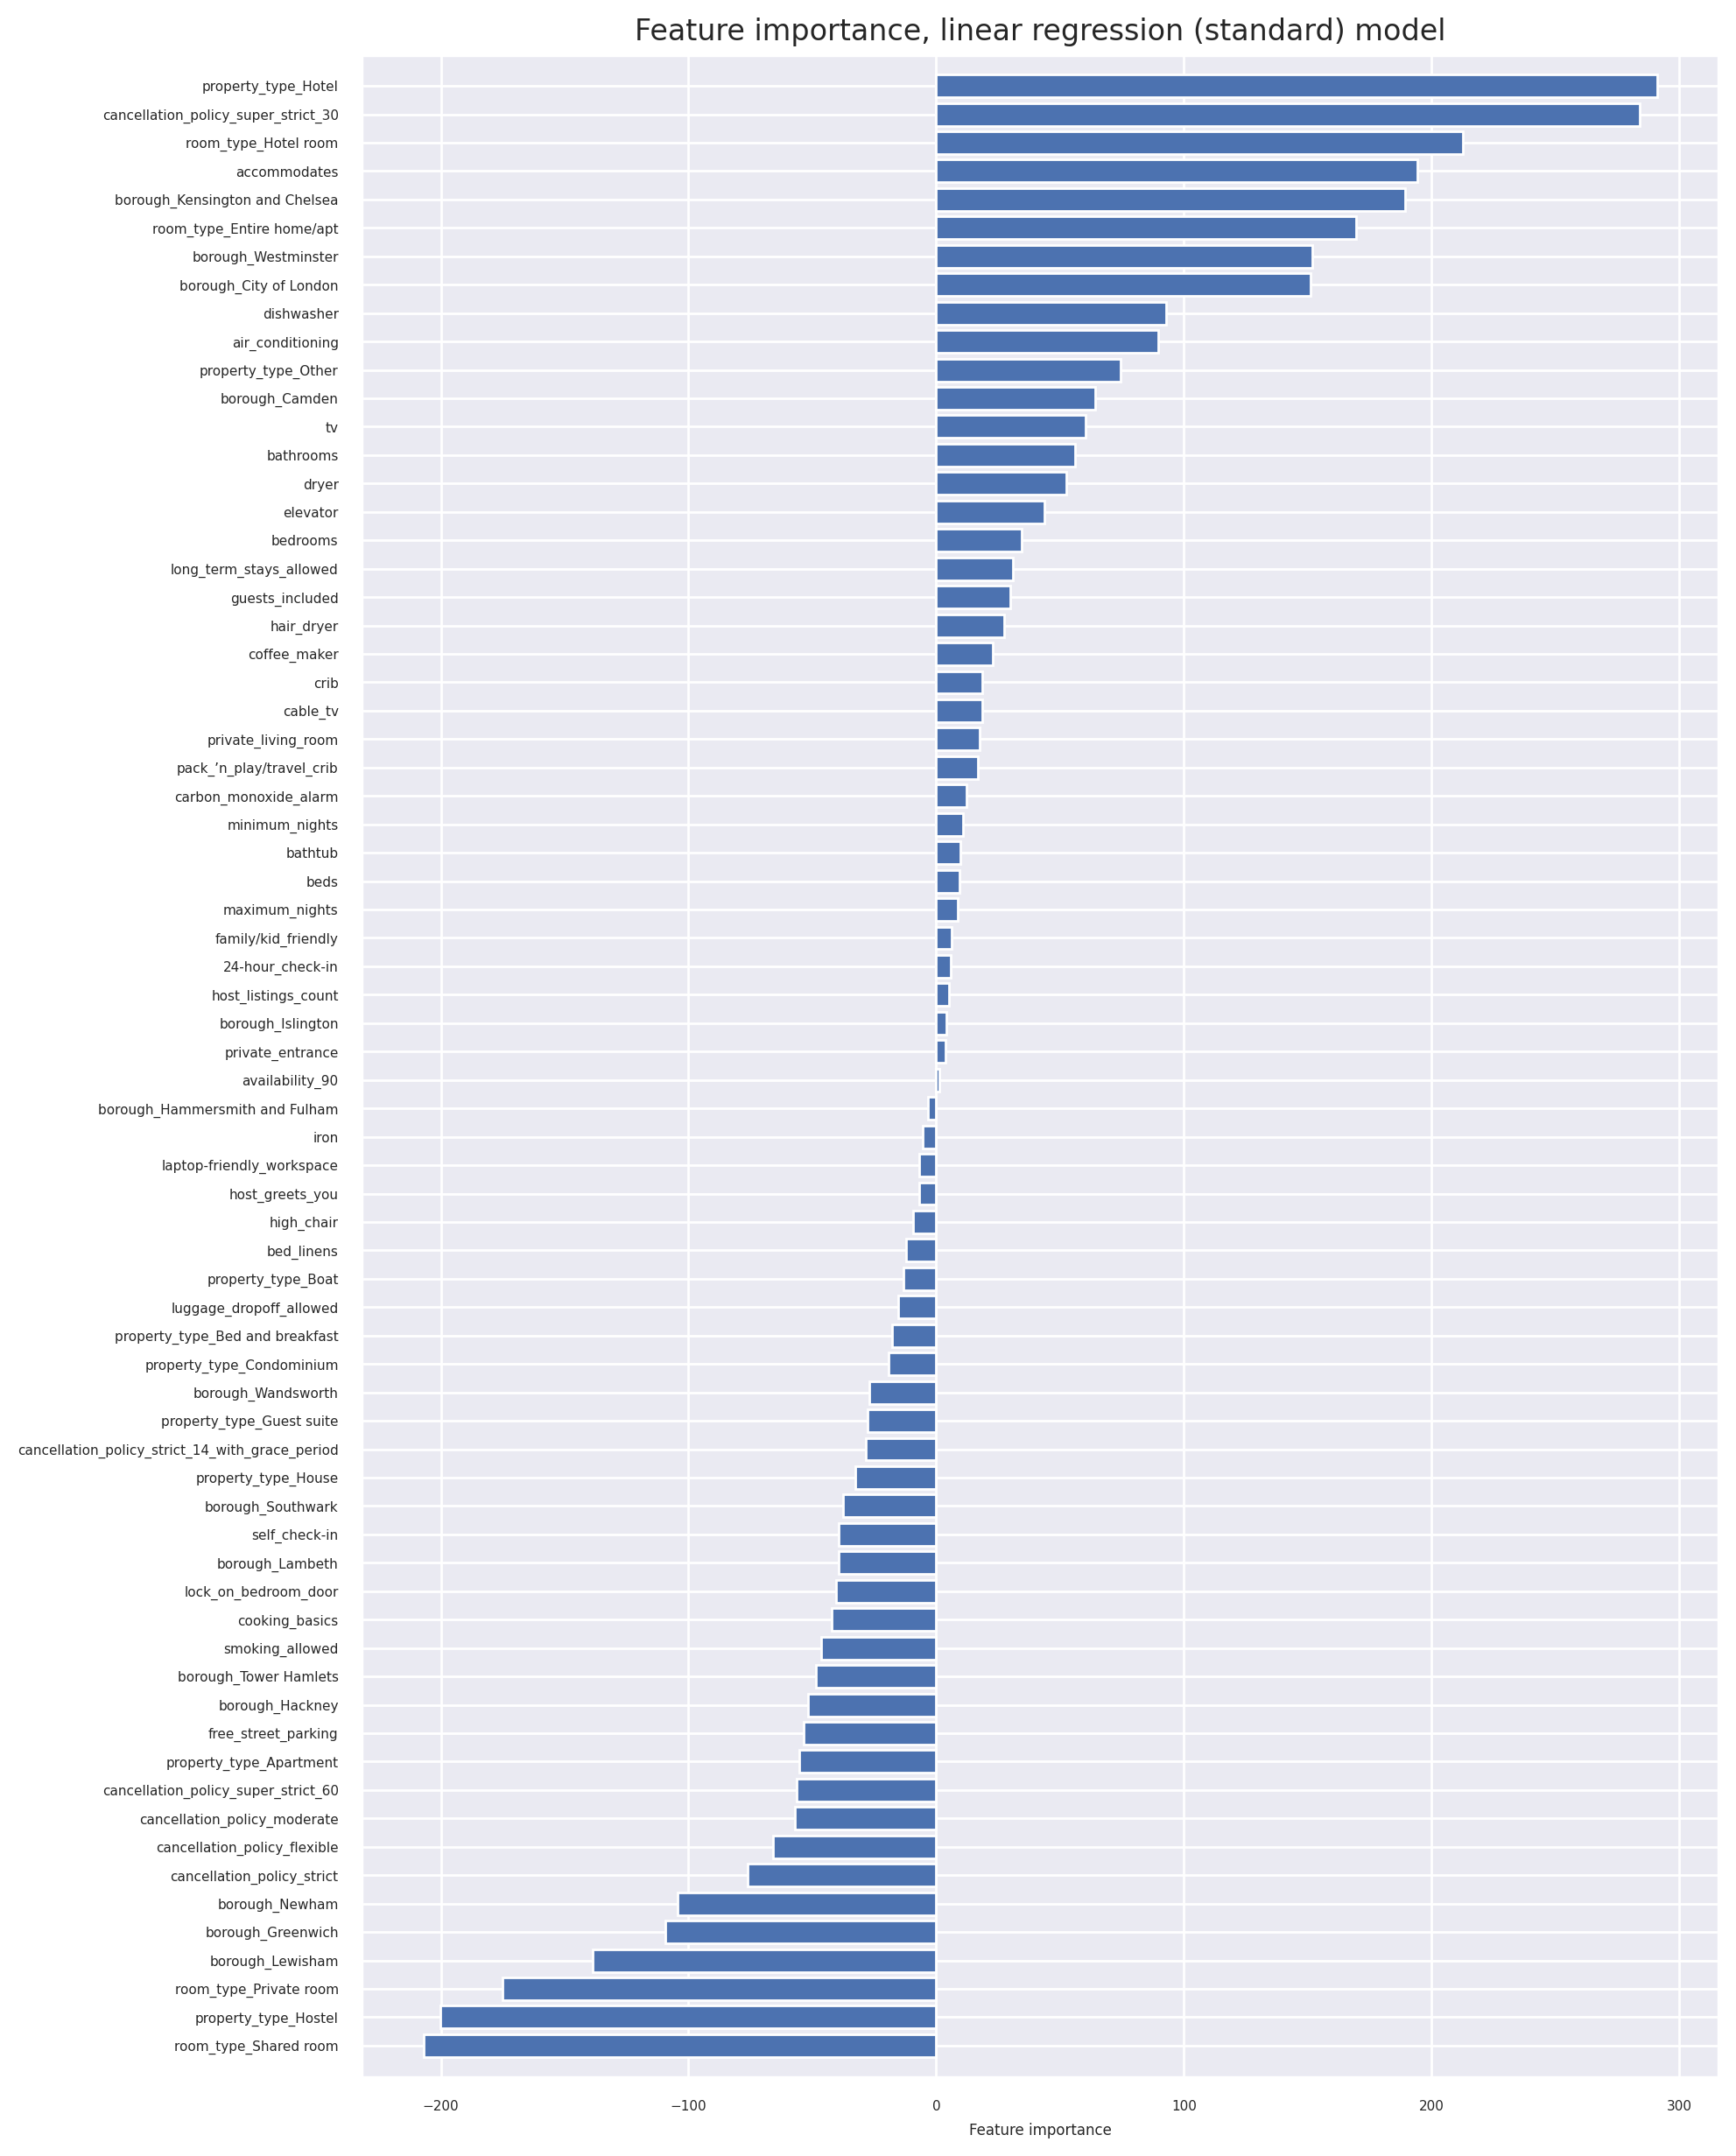

In [ ]:
# plot dataframe of feature importance as horizontal bar
plt.figure(figsize=(10, 15))
plt.barh(weights_lreg.index, weights_lreg.weight, align='center')
plt.title("Feature importance, linear regression (standard) model", fontsize=12)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In our regression model, we observe that the non-amenity features of the dataset exhibit greater importance than the amenities as a predictor for `price`. Meanwhile, the R-square value suggests that the model explains slightly over half of dependent variable variation, which offers moderate performance given the complexity of housing dynamics in a major urban centre. We now consider alternative regression models, beginning with Ridge Regression (L2).

**Ridge Regression (L2):** We continue our review of regression models with Ridge Regression using SciKit-Learn's `linear_model.Ridge` class. This flavour of regression is typically applied to resolve issues of multicolinearity among features in a dataset. While we believe we have controlled for this manually, we want to determine if we may do better through use of this modelling approach.

In [ ]:
# deploy in event of multicollinearity
# get train and testing sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=42)
# get columnar names for X index
X_ind = X_train.columns
# scale train and test data sets using standard scaler
X_train = s_scaler.fit_transform(X_train)
X_test = s_scaler.transform(X_test)

# generate ridge regression model and fit
reg_ridge = linear_model.Ridge()
reg_ridge.fit(X_train, y_train)

# generate prediction from model
y_pred = reg_ridge.predict(X_test)

# get r2 score using actual vs predictive datasets
ridge_score = metrics.r2_score(y_test, y_pred)
print("R-squared score, ridge regression (L2): ", ridge_score)

R-squared score, ridge regression (L2):  0.5748165859717784


In [ ]:
# generate dataframe of weights afforded to each feature (feature importance)
weights_ridge = pd.DataFrame(reg_ridge.coef_, columns=['weight'], index=X_ind)
weights_ridge.sort_values(by='weight', inplace=True)
weights_ridge

weight
room_type_Private room                          -85.825281
borough_Lewisham                                -29.033368
cooking_basics                                  -20.488829
borough_Newham                                  -19.950003
borough_Tower Hamlets                           -19.603829
borough_Greenwich                               -19.391971
borough_Hackney                                 -18.675018
lock_on_bedroom_door                            -16.467126
room_type_Shared room                           -15.918080
self_check-in                                   -14.202072
free_street_parking                             -13.909252
borough_Lambeth                                 -13.335194
smoking_allowed                                 -12.752490
borough_Southwark                               -12.596213
borough_Wandsworth                               -9.209101
cancellation_policy_flexible                     -8.441456
property_type_Apartment                          -7.334191
property_type_Hostel                             -6.302896
bed_linens                                       -5.756971
luggage_dropoff_allowed                          -5.428534
cancellation_policy_moderate                     -3.823466
borough_Hammersmith and Fulham                   -3.266335
laptop-friendly_workspace                        -3.219393
host_greets_you                                  -2.446238
iron                                             -2.275308
high_chair                                       -1.868003
borough_Islington                                -1.601501
cancellation_policy_super_strict_60              -0.392282
cancellation_policy_strict                       -0.328874
property_type_Guest suite                         0.692162
property_type_Boat                                0.892670
24-hour_check-in                                  1.397312
property_type_Bed and breakfast                   1.493802
private_entrance                                  1.609960
property_type_House                               1.807554
family/kid_friendly                               2.671088
bathtub                                           2.680301
property_type_Condominium                         3.084009
pack_’n_play/travel_crib                          3.214932
crib                                              3.521697
property_type_Other                               5.352321
carbon_monoxide_alarm                             6.055706
private_living_room                               6.206477
cable_tv                                          6.490751
maximum_nights                                    7.772952
minimum_nights                                    8.125328
beds                                              9.000728
coffee_maker                                      9.554496
cancellation_policy_strict_14_with_grace_period   9.608587
host_listings_count                              10.657344
borough_City of London                           12.284907
hair_dryer                                       12.528299
guests_included                                  12.541577
long_term_stays_allowed                          12.555189
borough_Camden                                   15.451159
cancellation_policy_super_strict_30              18.277078
elevator                                         18.786537
room_type_Hotel room                             18.791428
air_conditioning                                 21.344692
bathrooms                                        22.474388
property_type_Hotel                              23.078145
dryer                                            25.992833
tv                                               28.355000
dishwasher                                       38.837745
bedrooms                                         43.858325
availability_90                                  44.241823
borough_Westminster                              47.515274
borough_Kensington and Chelsea          

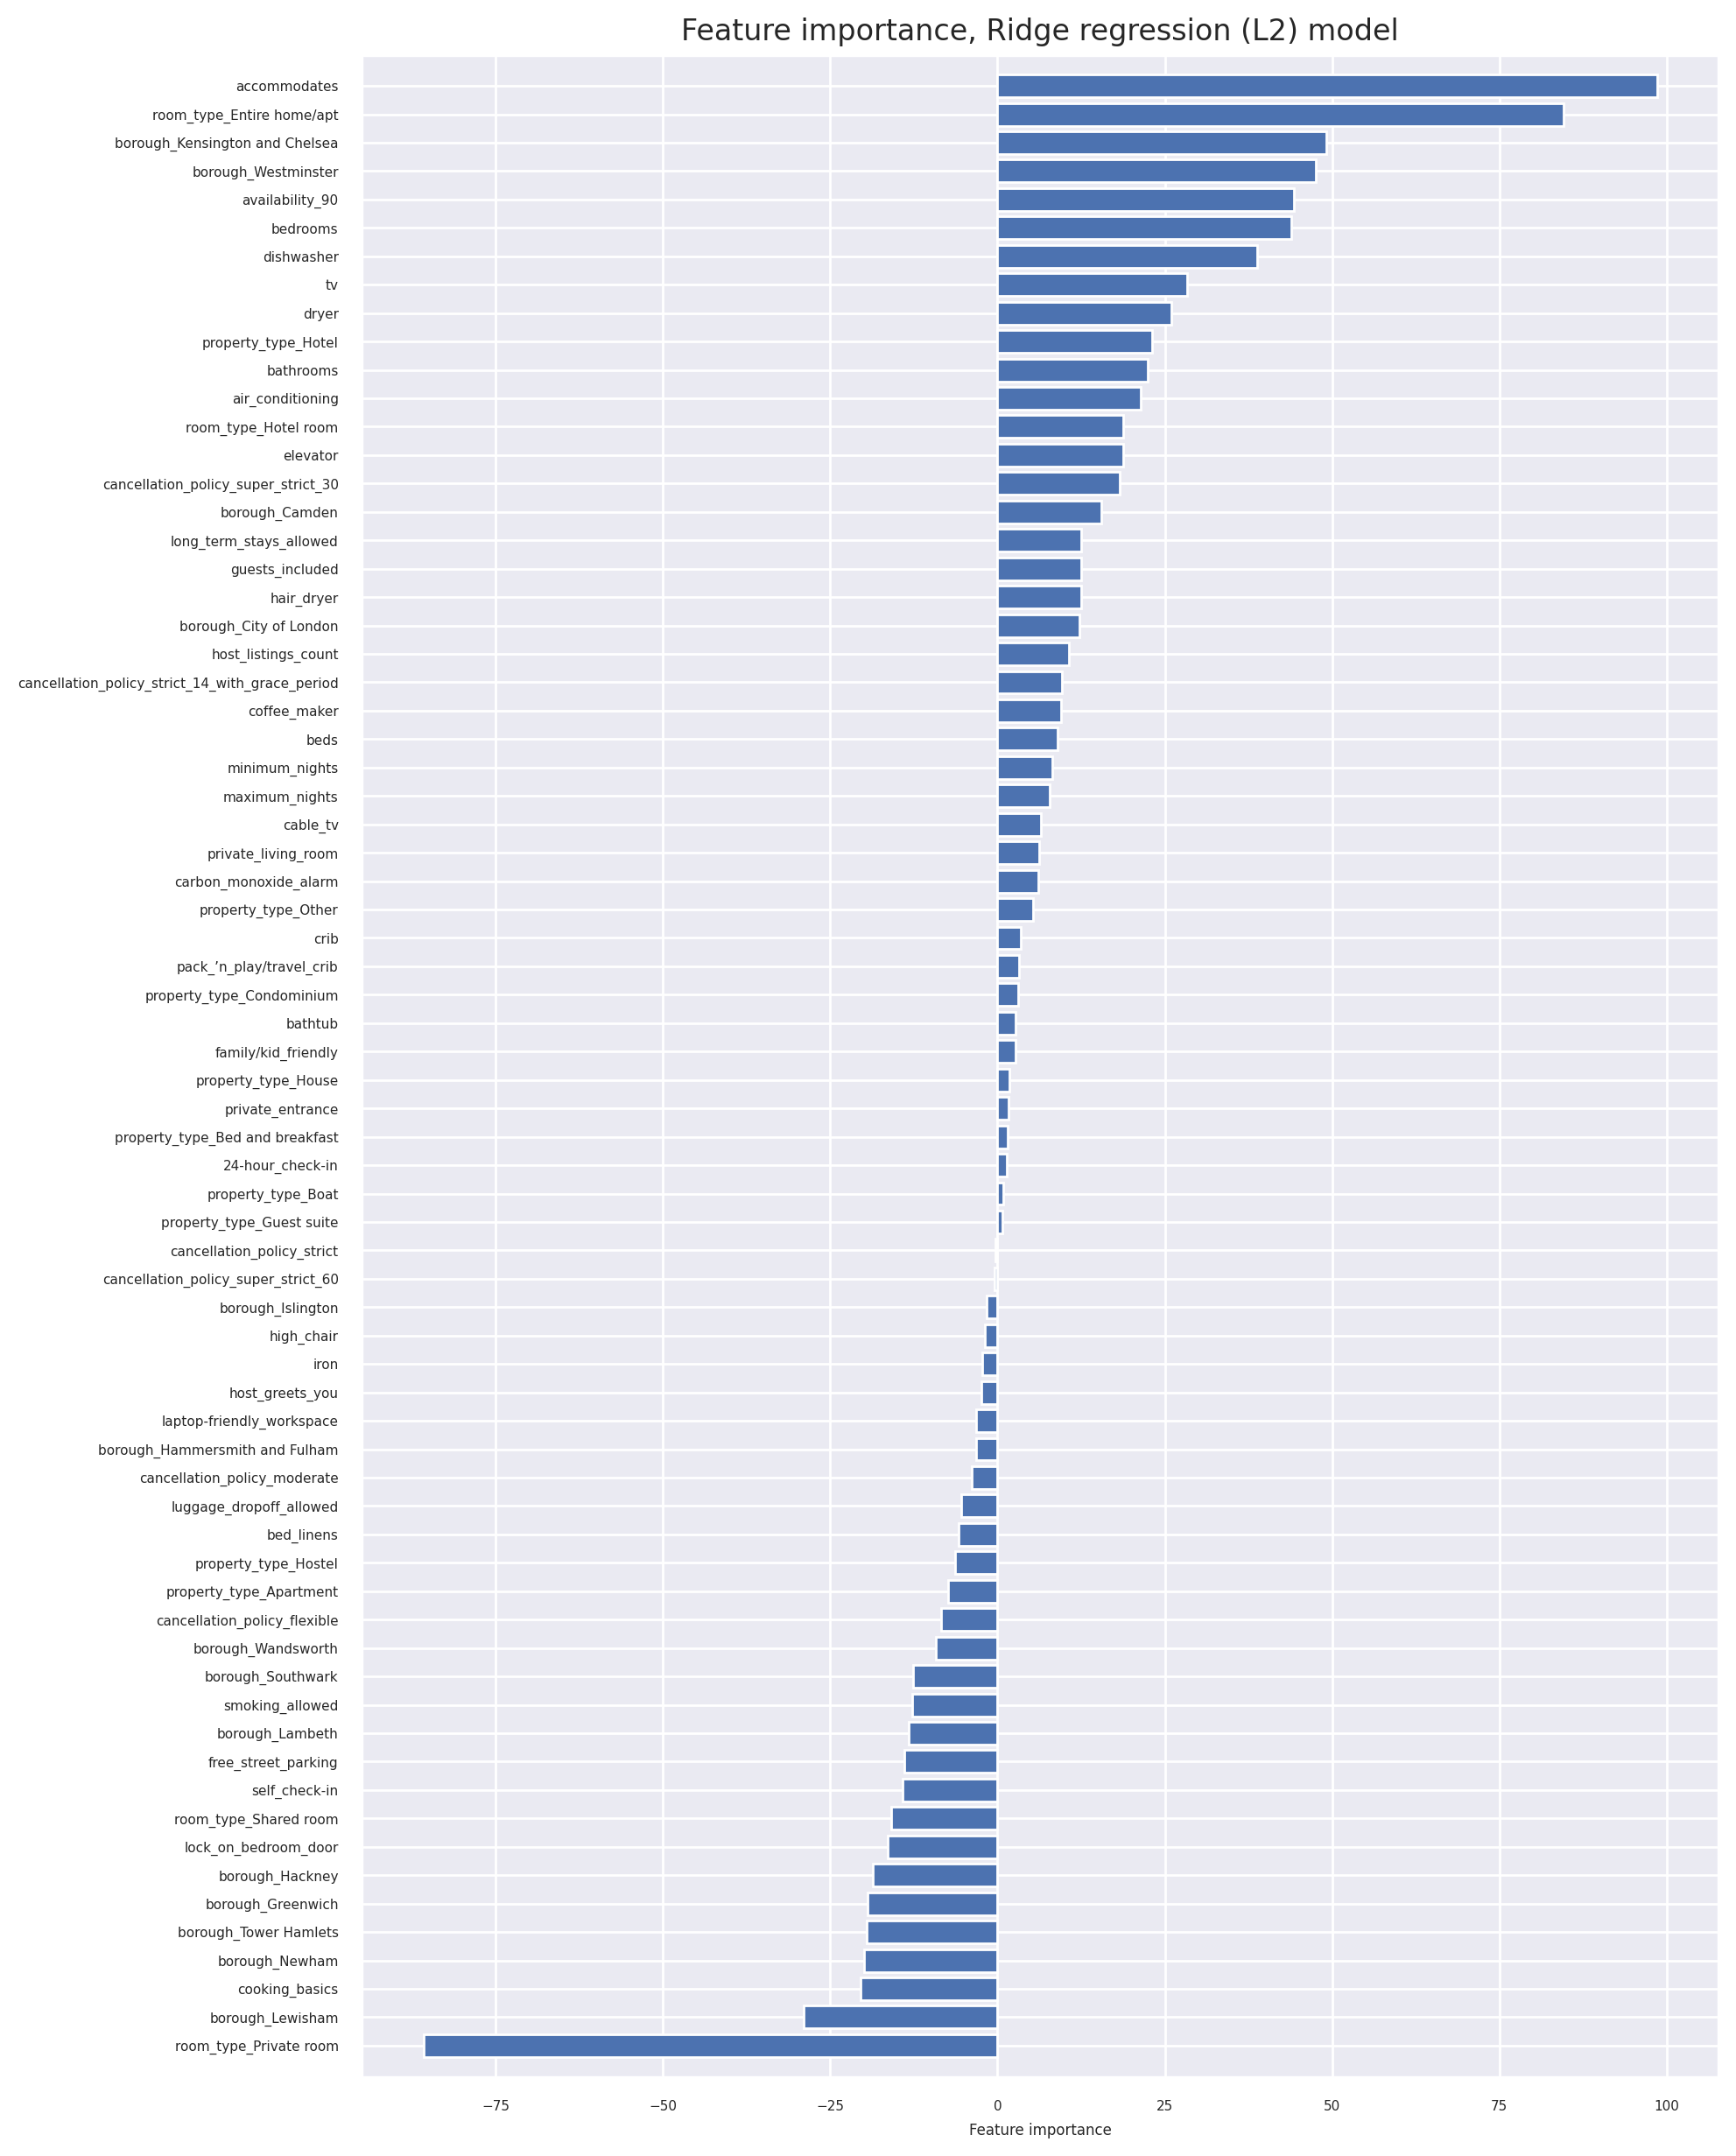

In [ ]:
# plot dataframe of feature importance as horizontal bar
plt.figure(figsize=(10, 15))
plt.barh(weights_ridge.index, weights_ridge.weight)
plt.title("Feature importance, Ridge regression (L2) model", fontsize=12)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

While feature importance ordering has changed from the standard linear regression approach, there is no significant divergence in the R-square value from the preceding model. We will discuss the feature importance implications in a later section of this notebook.

**Lasso Regression (L1):** We continue our review of regression models with Lasso Regression using SciKit-Learn's `linear_model.Lasso` class. We reason that as our dataframe has a large number of features, some may be redundant/irrelevant to our posited relationship and so this flavour of regression may be of use.

In [ ]:
# lasso does not work well with multi-colinearity but may help override redundant features
# get train and testing sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=42)
# get columnar names for X index
X_ind = X_train.columns
# scale train and test data sets using standard scaler
X_train = s_scaler.fit_transform(X_train)
X_test = s_scaler.transform(X_test)

# generate lasso regression model and fit
reg_las = linear_model.Lasso()
reg_las.fit(X_train, y_train)

# generate prediction from model
y_pred = reg_las.predict(X_test)

# get r2 score using actual vs predictive datasets
las_score = metrics.r2_score(y_test, y_pred)
print("R-squared score, lasso regression (L1): ", las_score)

R-squared score, lasso regression (L1):  0.5749300346199221


In [ ]:
# generate dataframe of weights afforded to each feature (feature importance)
weights_las = pd.DataFrame(reg_las.coef_, columns=['weight'], index=X_ind)
weights_las.sort_values(by='weight', inplace=True)
weights_las

weight
room_type_Private room                           -27.858027
borough_Lewisham                                 -20.389433
cooking_basics                                   -17.880004
lock_on_bedroom_door                             -15.742779
free_street_parking                              -13.779938
self_check-in                                    -12.496570
smoking_allowed                                  -12.021691
borough_Newham                                   -11.963320
borough_Greenwich                                -11.914988
property_type_Apartment                           -7.934573
room_type_Shared room                             -6.074762
borough_Hackney                                   -5.795866
property_type_Hostel                              -5.449211
borough_Tower Hamlets                             -5.321356
bed_linens                                        -3.911658
luggage_dropoff_allowed                           -3.539618
cancellation_policy_flexible                      -3.427680
laptop-friendly_workspace                         -1.876391
borough_Lambeth                                   -1.816288
borough_Southwark                                 -1.185783
host_greets_you                                   -1.120326
iron                                              -0.214532
property_type_Boat                                 0.000000
property_type_Guest suite                          0.000000
property_type_House                                0.000000
cancellation_policy_moderate                      -0.000000
cancellation_policy_strict                        -0.000000
borough_Wandsworth                                 0.000000
high_chair                                        -0.000000
cancellation_policy_super_strict_60                0.000000
property_type_Bed and breakfast                    0.410809
private_entrance                                   0.522834
24-hour_check-in                                   0.714079
bathtub                                            1.724651
property_type_Condominium                          1.839226
pack_’n_play/travel_crib                           1.888579
family/kid_friendly                                2.207307
crib                                               2.324631
property_type_Other                                4.163688
carbon_monoxide_alarm                              4.764105
private_living_room                                5.170488
borough_Hammersmith and Fulham                     5.528821
cable_tv                                           5.789477
maximum_nights                                     7.519188
minimum_nights                                     7.566807
coffee_maker                                       7.867406
borough_Islington                                  8.180339
beds                                               8.318544
host_listings_count                               10.462139
long_term_stays_allowed                           10.620651
hair_dryer                                        10.656555
guests_included                                   12.040379
cancellation_policy_strict_14_with_grace_period   13.669739
borough_City of London                            15.021316
elevator                                          17.544117
cancellation_policy_super_strict_30               18.141295
air_conditioning                                  21.029462
bathrooms                                         21.888014
property_type_Hotel                               22.216092
dryer                                             25.811798
borough_Camden                                    26.041499
tv                                                28.277647
room_type_Hotel room                              28.354223
dishwasher                                        37.528878
bedrooms                                          42.878317
availability_90                                   43.712815
borough_Kensington and Chelsea   

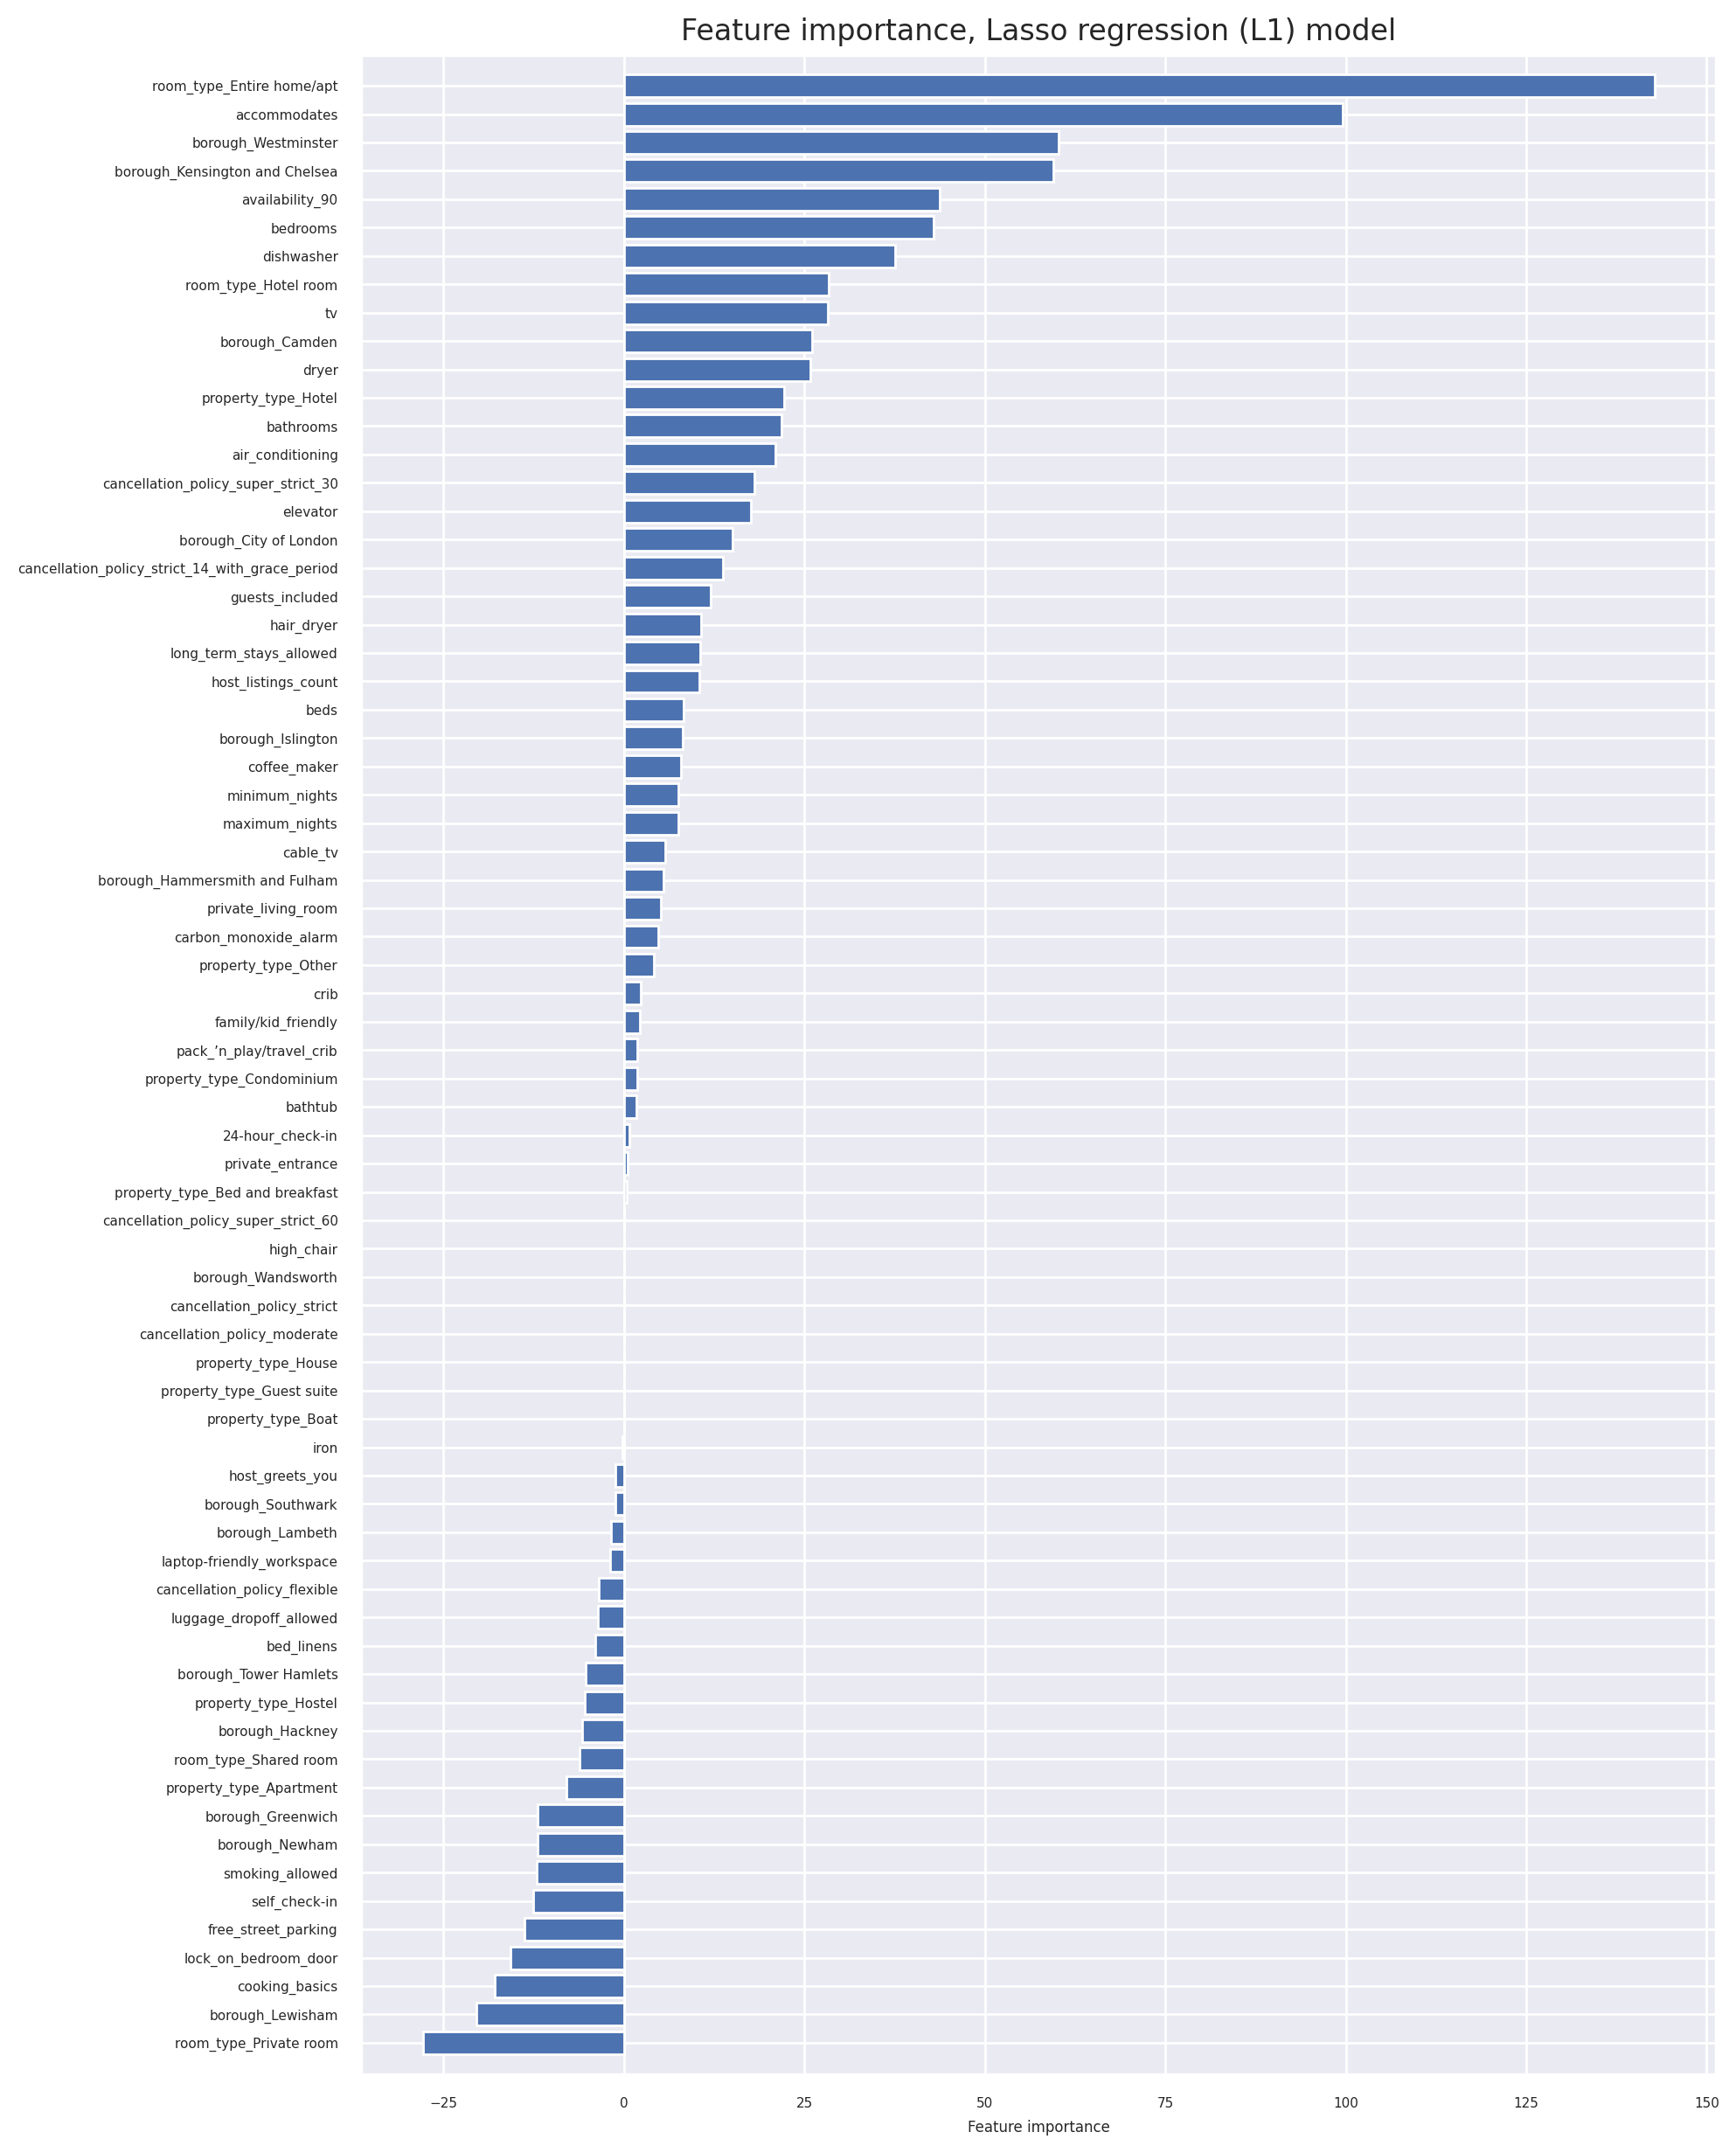

In [ ]:
# plot dataframe of feature importance as horizontal bar
plt.figure(figsize=(10, 15))
plt.barh(weights_las.index, weights_las.weight)
plt.title("Feature importance, Lasso regression (L1) model", fontsize=12)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

As we might expect, gaps are observed in the data visualization as irrelevant results are ignored. As before, there is no significant divergence in the R-square value from the preceding models.

**ElasticNet (L1/L2):** We continue our review of regression models with ElasticNet Regression using SciKit-Learn's `linear_model.ElasticNet` class. This is used as a compromise between the preceding two regression approaches and may prove the most optimal given a balance between feature irrelevance and prospective multicolinearity.

In [ ]:
# get train and testing sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=42)
# get columnar names for X index
X_ind = X_train.columns
# scale train and test data sets using standard scaler
X_train = s_scaler.fit_transform(X_train)
X_test = s_scaler.transform(X_test)

# generate elastic net regression model and fit
reg_eln = linear_model.ElasticNet(alpha=0.1, l1_ratio=0.5)
reg_eln.fit(X_train, y_train)
# generate prediction from model
y_pred = reg_eln.predict(X_test)

# get r2 score using actual vs predictive datasets
eln_score = metrics.r2_score(y_test, y_pred)
print("R-squared score, ElasticNet (L1/L2): ", eln_score)

R-squared score, ElasticNet (L1/L2):  0.5749636109091181


In [ ]:
# generate dataframe of weights afforded to each feature (feature importance)
weights_eln = pd.DataFrame(reg_eln.coef_, columns=['weight'], index=X_ind)
weights_eln.sort_values(by='weight', inplace=True)
weights_eln

weight
room_type_Private room                          -83.671552
borough_Lewisham                                -27.428019
borough_Newham                                  -18.673495
borough_Tower Hamlets                           -18.480855
borough_Greenwich                               -18.088652
borough_Hackney                                 -17.561454
cooking_basics                                  -17.143760
lock_on_bedroom_door                            -17.097790
room_type_Shared room                           -15.216550
free_street_parking                             -14.185169
self_check-in                                   -13.326375
smoking_allowed                                 -12.746523
borough_Lambeth                                 -12.458714
borough_Southwark                               -11.610990
borough_Wandsworth                               -8.365568
cancellation_policy_flexible                     -8.313201
property_type_Apartment                          -6.670767
property_type_Hostel                             -6.015281
bed_linens                                       -5.183696
luggage_dropoff_allowed                          -5.097793
cancellation_policy_moderate                     -3.499872
laptop-friendly_workspace                        -2.752168
host_greets_you                                  -2.712595
borough_Hammersmith and Fulham                   -2.709553
iron                                             -1.191846
borough_Islington                                -1.163284
high_chair                                       -0.992200
cancellation_policy_strict                       -0.224028
cancellation_policy_super_strict_60              -0.000000
property_type_Guest suite                         0.224332
property_type_House                               0.275808
property_type_Boat                                0.745355
24-hour_check-in                                  1.271981
property_type_Bed and breakfast                   1.359999
private_entrance                                  2.686403
bathtub                                           2.806017
property_type_Condominium                         3.302836
pack_’n_play/travel_crib                          3.368670
crib                                              3.714808
family/kid_friendly                               3.795254
property_type_Other                               4.994453
private_living_room                               5.696585
carbon_monoxide_alarm                             5.919187
cable_tv                                          6.433131
maximum_nights                                    8.455466
minimum_nights                                    8.461957
coffee_maker                                      8.940362
cancellation_policy_strict_14_with_grace_period  10.038420
beds                                             10.474936
host_listings_count                              10.963654
long_term_stays_allowed                          11.811774
borough_City of London                           12.050618
hair_dryer                                       12.340810
guests_included                                  14.025370
borough_Camden                                   15.215339
elevator                                         17.784007
cancellation_policy_super_strict_30              17.853485
room_type_Hotel room                             18.058096
air_conditioning                                 21.107323
property_type_Hotel                              22.015256
bathrooms                                        22.332482
dryer                                            25.713200
tv                                               28.878169
dishwasher                                       36.074899
bedrooms                                         41.650530
availability_90                                  42.011412
borough_Westminster                              46.245035
borough_Kensington and Chelsea          

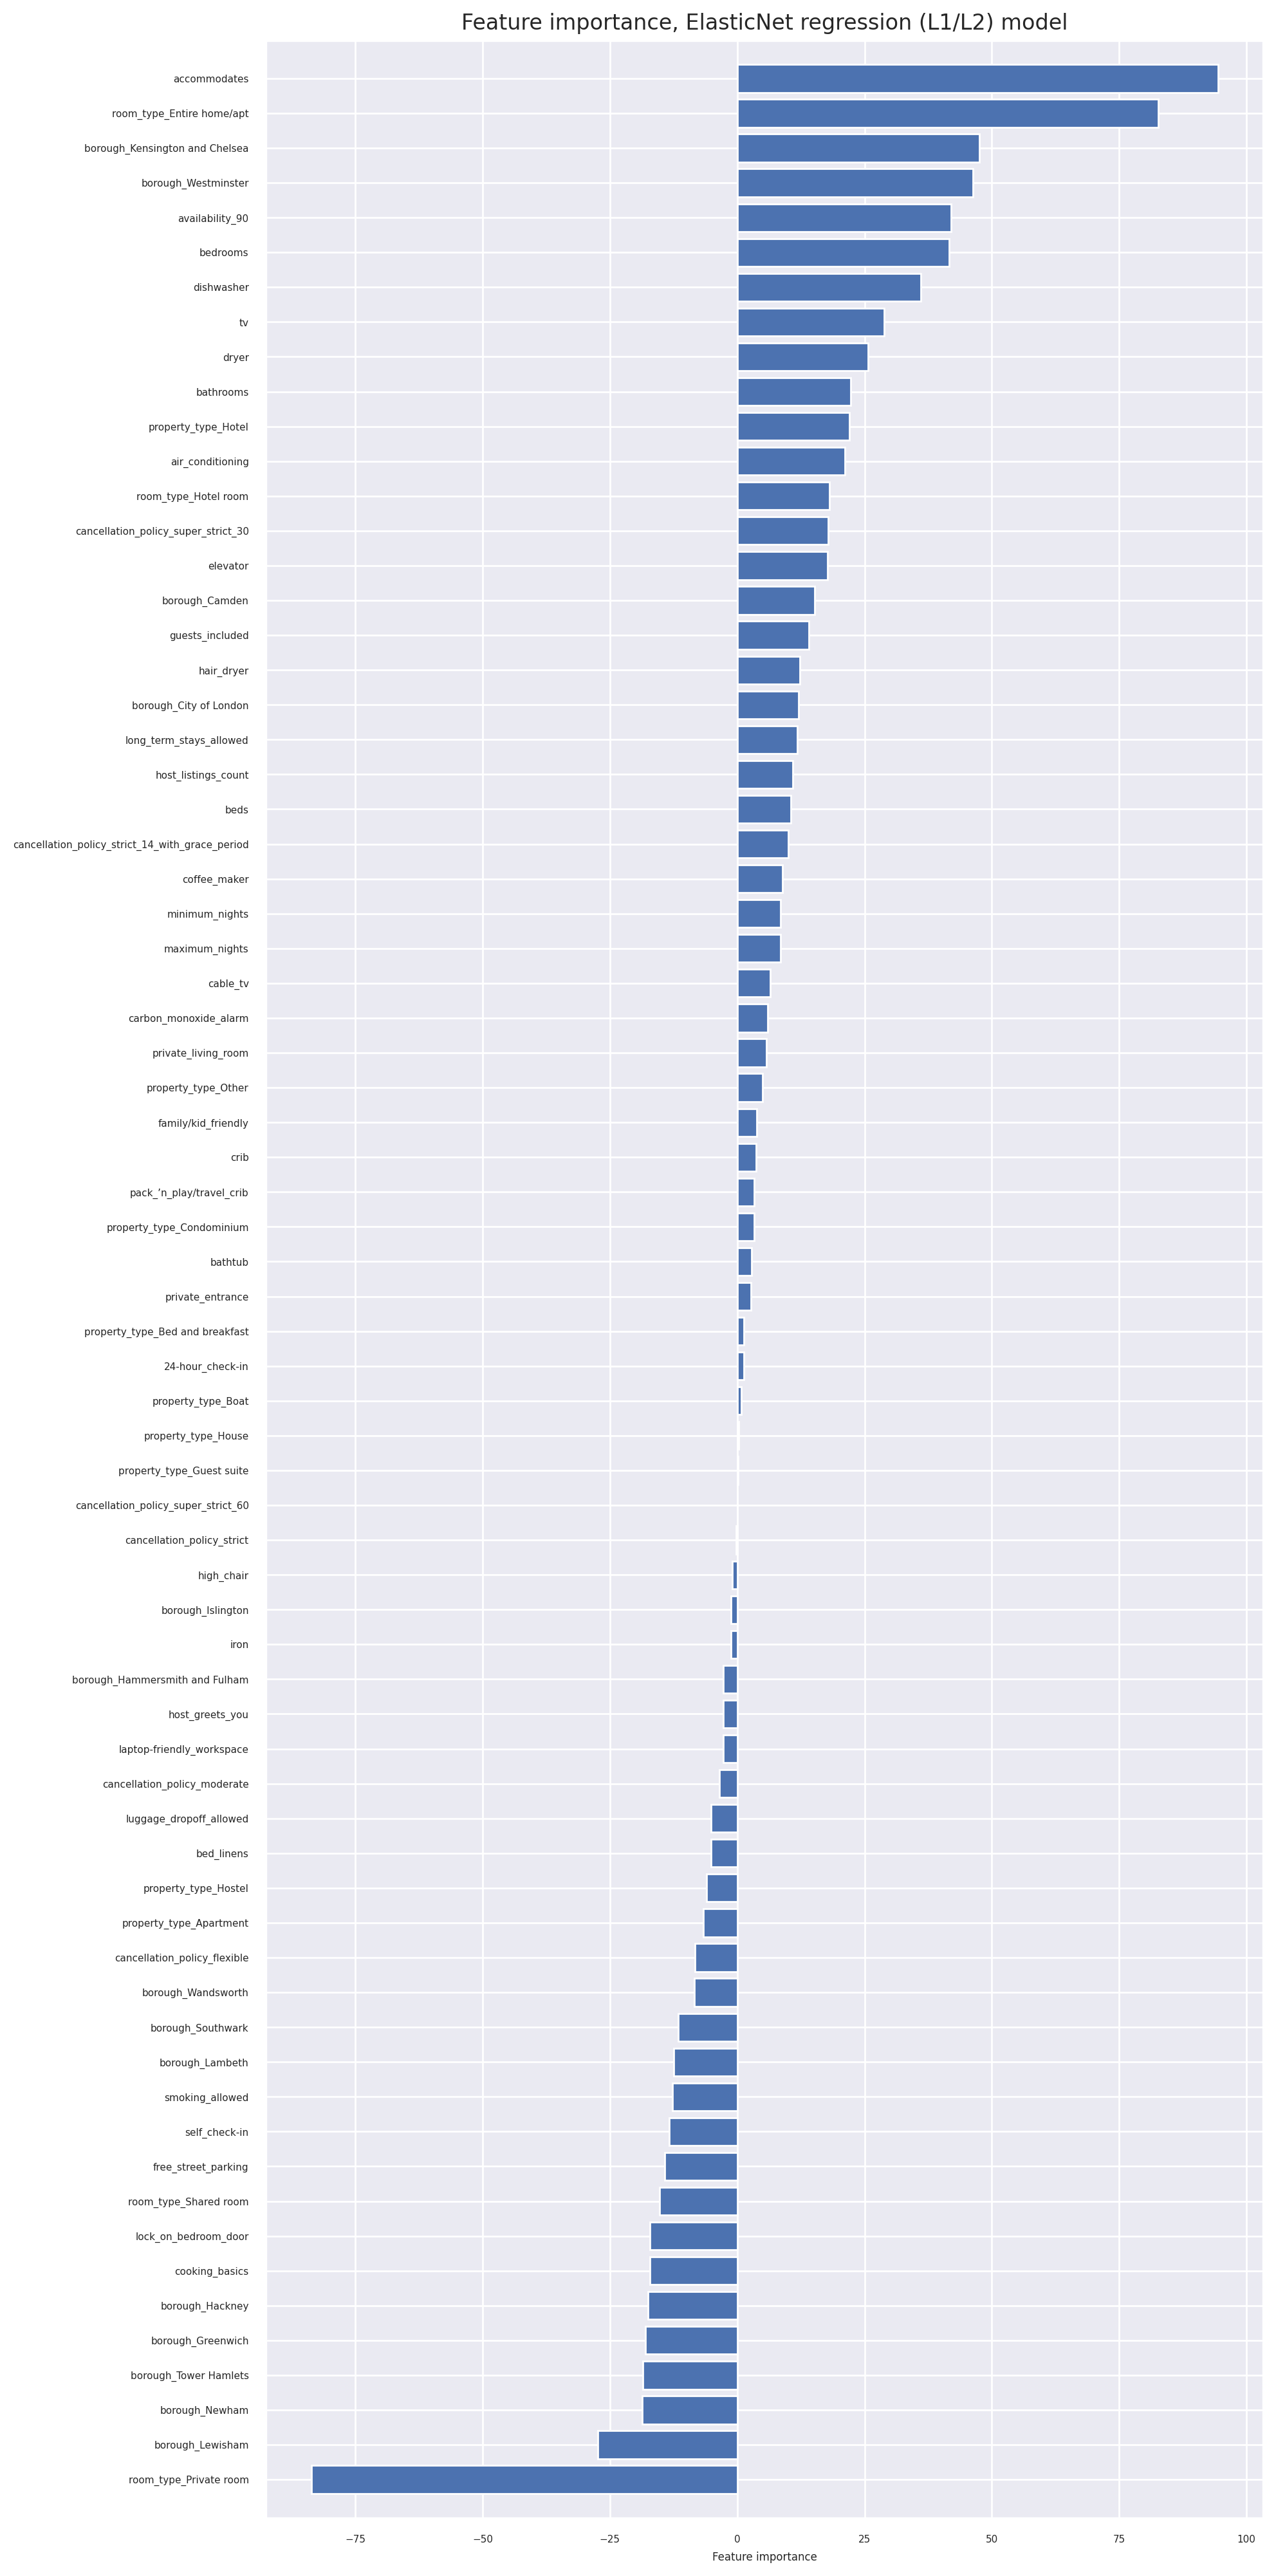

In [ ]:
# plot dataframe of feature importance as horizontal bar
plt.figure(figsize=(10, 25))
plt.barh(weights_eln.index, weights_eln.weight)
plt.title("Feature importance, ElasticNet regression (L1/L2) model", fontsize=12)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

As a synthesis of Lasso and Ridge approaches, we observe a balance in this output of those models' behaviours (similar alignment on feature importance, with some redundant features removed). We note again there is no significant divergence in the R-square value from the preceding models.

**Random Forest Regression:** We continue our review of regression models with Random Forest Regression using SciKit-Learn's `ensemble.RandomForestRegressor` class. This non-linear model may prove ideal for the complexity represented by the dataset: a dynamic housing market within a major world city and of interactions between different features in the dataset.

In [ ]:
# get train and testing sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)
# no need for standardization given tree partitioning
# generate random forest regression model and fit
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)
# generate prediction from model
y_test_pred = reg_rf.predict(X_test)
y_train_pred = reg_rf.predict(X_train)
# get r2 score using actual vs predictive datasets
rfr_score = metrics.r2_score(y_test, y_pred)
print("R-squared score, Random Forest Regression: ", rfr_score)

R-squared score, Random Forest Regression:  0.6435952844296493


With a higher R-squared score relative to the other approaches tried, we now concern ourselves with whether this model is overfitting to the supplied data. Let us represent this relationship visually using a `matplotlib` scatterplot.

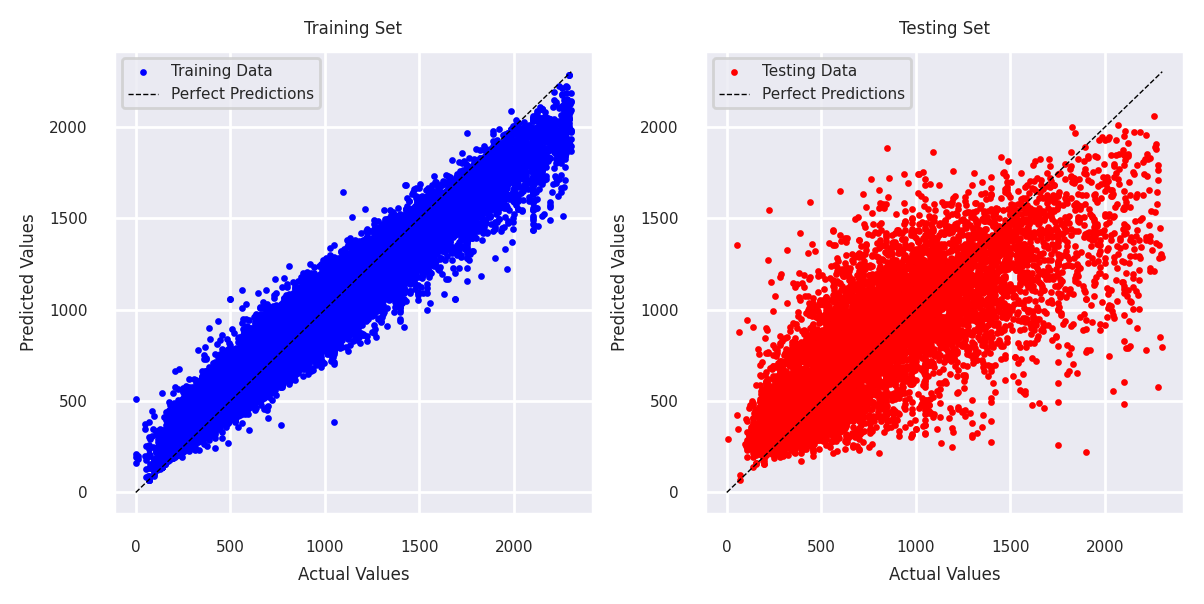

In [ ]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# Subplot for the training set
ax1.scatter(y_train, y_train_pred, color='blue', label='Training Data', s=2)
ax1.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
         color='black', linestyle='--', linewidth=0.5, label='Perfect Predictions')
ax1.set_title('Training Set')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.legend()

# Subplot for the testing set
ax2.scatter(y_test, y_test_pred, color='red', label='Testing Data', s=2)
ax2.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
         color='black', linestyle='--', linewidth=0.5, label='Perfect Predictions')
ax2.set_title('Testing Set')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
mse_train = metrics.mean_squared_error(y_train, y_train_pred)
mse_test = metrics.mean_squared_error(y_test, y_test_pred)
print(f'Mean Squared Error (MSE, Training): {mse_train}')
print(f'Mean Squared Error (MSE Testing): {mse_test}')

Mean Squared Error (Training): 10639.246557877252
Mean Squared Error (Testing): 75439.13400482887


We observe in the scatterplots for the training set a good clustering of points around the diagonal line (indicative of a perfect prediction). Conversely, we observe a deviation of points from the diagonal in the testing set in one direction. Furthermore, the MSE for the training set is significantly lower than that of the testing set. From this information and in context of a higher R-squared score relative to the other approaches, we posit that the `RandomForestRegressor` is overfitting. Given this observation, we simply move to our next model evaluation.

# 5. Linear Model Selection II: Neural Network

*Description:* We now consider a neural network in the assessment of our study question using SciKit-Learn's `neural_network.MLPRegressor` class. A Multi-Layer Perceptron (MLP) regression model, which is a type of artificial neural network, can be considered when dealing with complex, non-linear relationships in the data or when traditional linear regression models may not capture the underlying patterns effectively.

We have selected this model as it behaves not dissimilarly to a linear regression approach but with considerable benefits leveraged by a neural network. These benefits include:

* **Non-Linear Relationships:** MLPs are well-suited for capturing non-linear relationships between input features and the target variable
* **Complex Interactions:** When there are complex interactions and dependencies among features, MLPs can automatically learn and model these interactions.
* **High-Dimensional Data:** MLPs can handle high-dimensional input data efficiently.
* **Feature Learning:** MLPs have the capacity to learn hierarchical representations of features.
* **Regularization Techniques:** MLPs can benefit from various regularization techniques, such as dropout and weight decay, to prevent overfitting.

In the below cells, we will instantiate an `MLPRegressor` object using training and test data in an 80:20 ratio, and fit to model. We will then get predictions and view the result relative to the prior non-neural network models we have reviewed to determine, on a trial basis, the utility of a neural network application relative to the less complex regression models we have seen.

In [ ]:
# get train and testing sets using train_test_split with 80% train data / 20% test data
X_train_default, X_test_default, y_train_default, y_test_default = train_test_split(features, target, test_size=0.20, random_state=42)
# scale train and test data sets using standard scaler
X_train_default = s_scaler.fit_transform(X_train_default)
X_test_default = s_scaler.transform(X_test_default)
# generate multi-layer perceptron regressor with following hyperparams
mlp_reg_default = MLPRegressor(hidden_layer_sizes=(150, 100, 50),
                       max_iter = 500,
                       activation = 'relu',
                       solver = 'adam')
# fit to model
mlp_reg_default.fit(X_train_default, y_train_default)

MLPRegressor(hidden_layer_sizes=(150, 100, 50), max_iter=500)

In [ ]:
# get predictions
y_pred_default = mlp_reg_default.predict(X_test_default)
# get and print sample of actual v. predicted results
df_eval_default = pd.DataFrame({'Actual': y_test_default, 'Predicted': y_pred})
# view result
df_eval_default.head()

Actual  Predicted
298     392.0    682.430
4508    280.0    342.367
12625   890.0   1280.800
15542   239.0    368.900
16770    56.0   1308.180

**Preliminary review:** Unlike the prior models, there is no intrinsic feature importance available within the `MLPRegressor` model, so we may not deploy a comparable graph as we have done before.

We do observe some suboptimal behaviour with respect to both the R-square value relative generated by the neural network to the predecessor models and the loss curve, which takes a significant number of iterations to converge (before abruptly decreasing) at no small cost to performance and time. That is, we know we can yield a more accurate value with less effort.

We also note that the hyperparameters used to tune the `MLPRegressor` model were a selected 'best-guess' default that did not yield an ideal outcome. Given the above, we consider if we can do better.

In [ ]:
# print summary information
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_default, y_pred_default))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_default, y_pred_default))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_default, y_pred_default)))
print("R-squared score, Multi-layer Perceptron Regression: ", metrics.r2_score(y_test_default, y_pred_default))

Mean Absolute Error: 245.3733583989385
Mean Squared Error: 134759.84090839504
Root Mean Squared Error: 367.0965008119732
R-squared score, Multi-layer Perceptron Regression:  0.3635741564790458


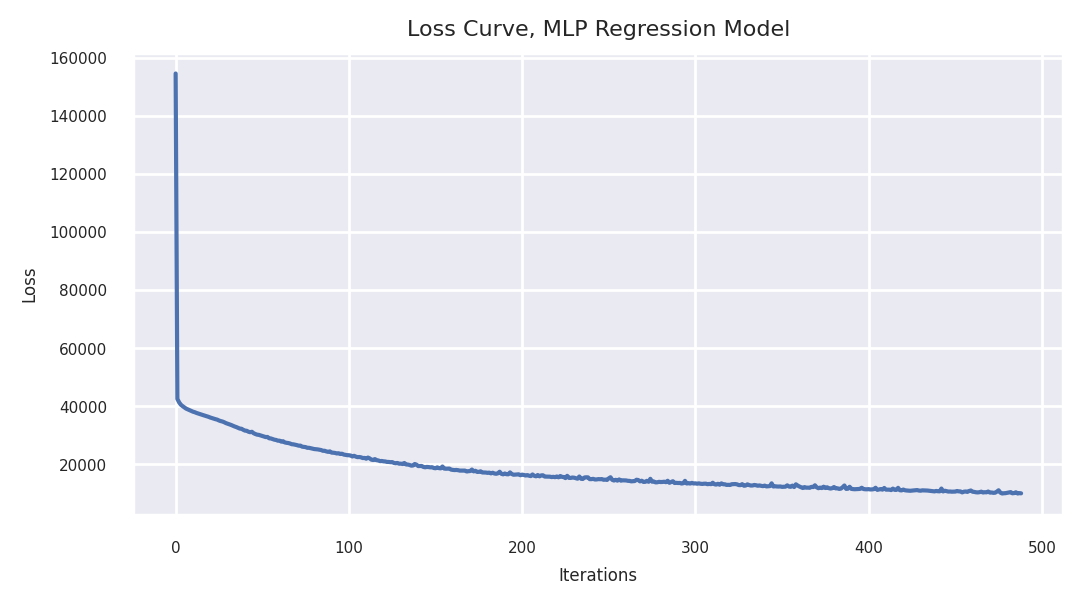

In [ ]:
# plot loss curve for training model
plt.figure(figsize=(6, 3))
plt.plot(mlp_reg_default.loss_curve_)
plt.title("Loss Curve, MLP Regression Model", fontsize=8)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

**GridSearchCV and RandomizedSearchCV:** We now consider methods to tune the MLP model's hyperparameters as a means to improve model performance. As we cannot say that our "best-guess" hyperparameter choices are indeed optimal, we rely on alternative approaches. Rather than exhaustively trialling different hyperparameters in code ourselves, we will instead rely on automated methods to test hyperparameter performance.

In `GridSearchCV`, we automate the tuning of hyperparameters in an [exhaustive search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). We will pass predefined values for hyperpararmeters to the function which will then try *all combinations* of values. This will provide output of accuracy and loss for each combination in a cached format and thus we may choose the one with the best performance.

In `RandomizedSearchCV`, we automate the tuning of hyperparameters in a randomized search. We pass the same predefined values for hyperparameters to the function, which per [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), "implements a 'fit' and 'score' method ... in contrast to `GridSearchCV`, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions".

Among parameters to the respective functions, we are most concerned with:

```
Estimator: The model instance for which we want to review the hyperparameters
Params_grid/random: A dictionary object that contains the combination of hyperparameters we want to test
n_jobs: The number of processes we wish to run in parallel for the task; we select -1 as will use all processors available to us
cv: The numer of cross-validation we try for each selected set of hyperparameters
```

For our process, we initially ran a `GridSearchCSV` (November, 21, 2023) to exhaustively derive a set of best parameters for our purposes. The time required to do so was significant at approximately 3 hours. When considering the operations "under-the-hood", this is appropriate: we are exhaustively checking every combination of passed parameters for a significant number of iterations across a dataframe with a large number of both rows and features.  This returned the following `grid.best_params_` result:

```
print(grid.best_params_)
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 100, 'solver': 'sgd'}
```

Though the `GridSearchCSV` yielded a return of the best parameters for the model as it existed at the time, later upstream changes to data composition and iteration on data cleaning effectively deprecated the parameters. Given the time commitment in training, we consider an alternative approach in `RandomizedSearchCSV` to tune the hyperparameters in a way that economizes on time with the prospect of a small hit to model quality. In the following cells, we built a `params_random` dictionary for `RandomSearchCSV`, run the random search, integrate the best hyperparameters into the `MLPRegressor` and re-run the model.

**Note:** We disregard any failed fits incurred during `RandomizedSearchCV` optimization of hyperparameters given that is, in effect, part of the process of finding optimal hyperparameters.

In [ ]:
# initialize hyperparameters dictionary
param_random = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    # ensure max_iter is above 150 given loss curve above
    'max_iter': [200, 500],
    'activation': ['tanh', 'relu', 'identity'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# conduct randomized search for mlp_reg given hyperparameters
random = RandomizedSearchCV(mlp_reg_default, param_random, n_jobs= -1, cv=3)
# fit on random
random.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 491, in _fit
    raise ValueError(
ValueError: Solve

RandomizedSearchCV(cv=3,
                   estimator=MLPRegressor(hidden_layer_sizes=(150, 100, 50),
                                          max_iter=500),
                   n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu',
                                                       'identity'],
                                        'alpha': [0.0001, 0.05],
                                        'hidden_layer_sizes': [(150, 100, 50),
                                                               (120, 80, 40),
                                                               (100, 50, 30)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'max_iter': [200, 500],
                                        'solver': ['sgd', 'adam']})

In [ ]:
# set best params to alias name
r_bparams = random.best_params_
# view best parameters found by RandomSearchCSV
print(r_bparams)

{'solver': 'adam', 'max_iter': 200, 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 50, 30), 'alpha': 0.05, 'activation': 'identity'}


**Note:** As reference, return (11/21/2023) of the `random.best_params_` yields:
```
{'solver': 'adam', 'max_iter': 200, 'learning_rate': 'constant', 'hidden_layer_sizes': (150, 100, 50), 'alpha': 0.0001, 'activation': 'identity'}
```



In [ ]:
# hardcode for time efficiency to avoid re-running
# r_bparams = {'solver': 'adam', 'max_iter': 200, 'learning_rate': 'constant', 'hidden_layer_sizes': (150, 100, 50), 'alpha': 0.0001, 'activation': 'identity'}

In [ ]:
# MODEL REINSTANTIATION USING BEST PARAMS
# get train and testing sets using train_test_split with 80% train data / 20% test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)
# get columnar names for X index
X_ind = X_train.columns
# scale train and test data sets using standard scaler
X_train = s_scaler.fit_transform(X_train)
X_test = s_scaler.transform(X_test)

# reinstantiate MLPRegressor objective given best parameters in dict r_bparms
mlp_reg = MLPRegressor(activation=r_bparams['activation'],
                       alpha=r_bparams['alpha'],
                       hidden_layer_sizes=r_bparams['hidden_layer_sizes'],
                       learning_rate=r_bparams['learning_rate'],
                       max_iter=r_bparams['max_iter'],
                       solver=r_bparams['solver'])
# fit training data on MLPRegressor
mlp_reg.fit(X_train, y_train)

MLPRegressor(activation='identity', alpha=0.05,
             hidden_layer_sizes=(100, 50, 30))

In [ ]:
# get predictions on optimized MLP
y_pred = mlp_reg.predict(X_test)
# get and print sample of actual v. predicted results
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval.head()

Actual    Predicted
298     392.0   648.887083
4508    280.0   195.692314
12625   890.0  1199.217941
15542   239.0   360.073181
16770    56.0  1032.877659

In [ ]:
# print summary information
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R-squared score, Multi-layer Perceptron Regression (opt.): ", metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 226.93114104591808
Mean Squared Error: 92333.99713868879
Root Mean Squared Error: 303.86509694054826
R-squared score, Multi-layer Perceptron Regression (opt.):  0.5639372856295007


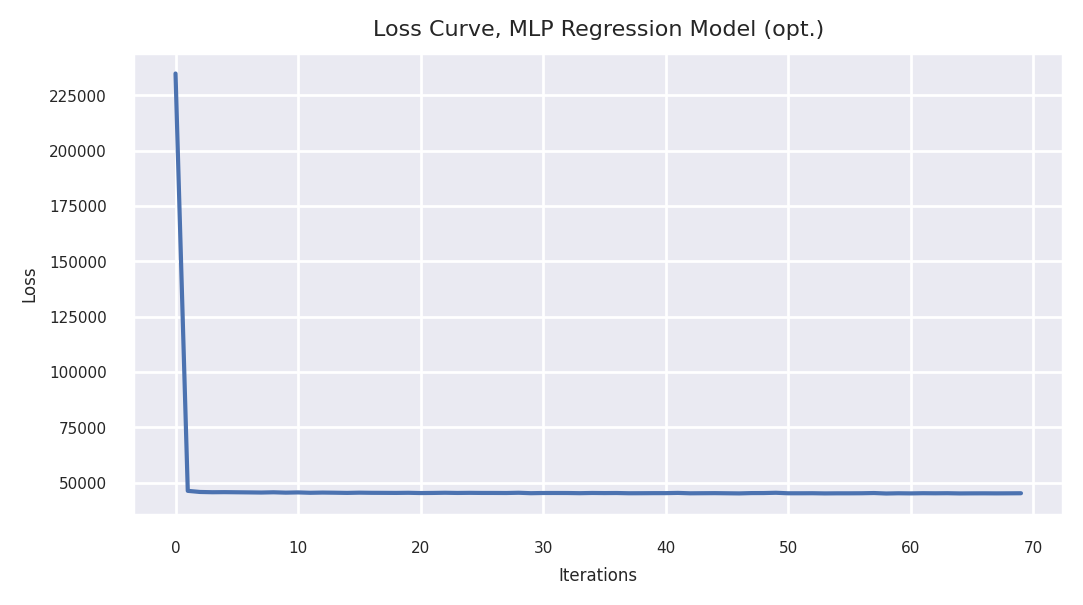

In [ ]:
# plot loss curve for MLP model training (opt.)
plt.figure(figsize=(6, 3))
plt.plot(mlp_reg.loss_curve_)
plt.title("Loss Curve, MLP Regression Model (opt.)", fontsize=8)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

**Secondary review:** As with the prior `MLPRegressor` model, there is no feature importance available within this regression model. We attempted to use the [SHapley Additive exPlanations (SHAP)](https://shap.readthedocs.io/en/latest/) package as a means to visually explain the feature importance derived by the neural network-driven model. This package uses game-theoretic principles to assist intepretation of machine learning methods. However, issues associated with our dataframe size proliferated. If the model was intepreted given the full dataset, Colaboratory would crash and reset runtime. If the model was intepreted given a digestible sample of overall training and testing data, the feature importance was clustered at the 0th x-axis tick and was not useful for meaningful interpretation.

Regardless of these technical challenges, we observe concerning behaviour with respect to the model that render these issues moot. While it has improved upon the prior neural network configuration given optimal hyperparemeters, we observe a steep decline of the loss curve. This *may* indicate effective learning, but could equally be attributed to overfitting of the model to the training data.

Additionally, we see the R-square value is equivalent to the standard supervised learning models despite the complexity, time, and performance requirements of the neural network. With this in mind, we eschew the use of a neural network for this dataset given optimal performance with a simpler model.

#6. Conclusions

We may now consider what we have learned from the review of data modelling with respect to the relationship between STR amenities and cumulative rental pricing. As no model performed particularly well relative to the others attempted, we will consider an aggregated list of features and their weightings drawn from each non-neural model. We will construct this aggregation by taking the index position of each feature drawn from each weighted feature model output and calculate the most persistent and highly-ranked across the surveyed models.

Given the similar performance of the non-neural models to the neural network models and the difficulty of accessing feature importance in the latter, we will necessarily have to discount the neural network modelling in our review. We similarly discount the output from the `RandomForestRegressor` model, given its observed overfitting behaviour.

In [ ]:
# build list of the diff dataframes of weights and indices output by models
l_m_weight = [weights_lreg, weights_ridge, weights_las, weights_eln]

# build an empty dict containing a feature - empty list combo as k, v
d_feat_pos = {feature: [] for feature in list(features)}
# create a dictionary to contain the average ranked position of features among models
d_avg_pos = {}

# for each model generated
for model in l_m_weight:
  # get the features as list
  f_index = list(model.index)
  # for each feature
  for index, feature in enumerate(f_index):
    # get the list item from dict at key
    l_item = d_feat_pos.get(feature, [])
    # if the list item is none, set list item to empty list
    if l_item is None:
      l_item = []
    # append the current index to the list item
    l_item.append(index)
    # append index to list item and then set to dict key value
    d_feat_pos[feature] = l_item

# for each feature and list of positions in dict d_feat_pos
for feature, l_pos in d_feat_pos.items():
  # collect the average position from list and store at k: feature in d_avg_pos
  d_avg_pos[feature] = np.mean(l_pos)

# sort d_avg_pos by values in descending order
d_avg_pos = dict(sorted(d_avg_pos.items(), key=lambda item: item[1], reverse=True))
# convert resulting sorted dict to dataframe
common_features = pd.DataFrame.from_dict(d_avg_pos, columns=['average'], orient="index")
# return the top 20 common features
common_features = common_features.head(20)

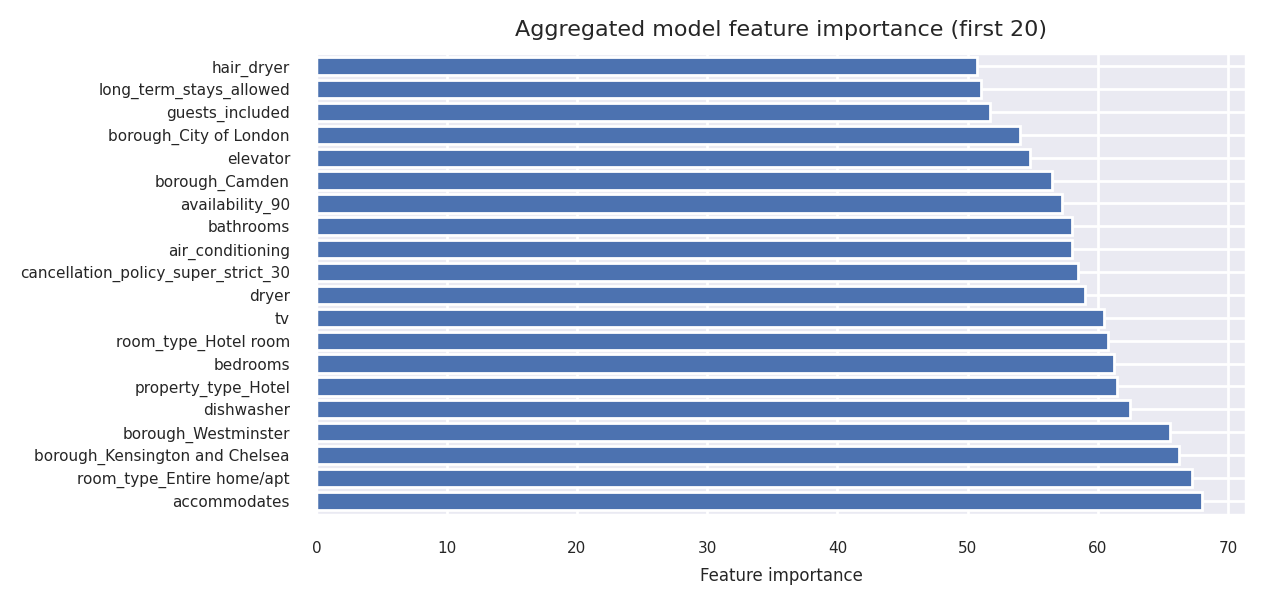

In [ ]:
# plot dataframe of feature importance as horizontal bar
plt.figure(figsize=(6, 3))
plt.barh(common_features.index, common_features.average)
plt.title("Aggregated model feature importance (first 20)", fontsize=8)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

**Discussion:**

We observe that the features that contribute most to the variance in cumulative prices `c_price` span categories of:
* **quality-of-life** (i.e. infrastructure and amenities such as elevator, hair dryer, television)
* **programmatic** (i.e. number of guests included in price, availability over 90 days, long-term stays allowed), and
* **geographic / spatial** (i.e. borough location of STR, type of room, number of beds and baths).

From a **quality-of-life** perspective, we observe that the provision of extra amenities can positively impact pricing, though in most instances, the amenities included in the graph are relatively trivial (i.e. a `hair_dryer` or a `tv`). The only listed amenity with a significant cost attached is the `elevator`, which is a sentinel indicator for the age of the building (newer than 1820), the height of the building, accessibility to those with mobility challenges, and maintenance costs (and their potential to be passed to the consumer). Across the amenity class of features, there is very little variation among them with regard to their influence on pricing (that is, the presence of an `elevator` is equally as likely to influence pricing as is a `hair_dryer`).

We consider the **programmatic** perspective; that is, the rules established by the STR proprietor or the hard constraints imposed by the STR property's design and orientation. Programmatic features include the number of `guests_included`, the number of people accommodated by the STR, the cancellation policy, and whether `long_term_stays_allowed`. Here, we observe the feature `accommodates`, as the carrying capacity of the STR property, as the most significant global predictor of STR pricing. This is intuitive such that we would expect a property able to accommodate multiple guests as being more generally expensive than a property accommodating one guest.

Finally, from a **geographic** perspective, we consider both borough membership and the defining characteristics of the STR property. Indeed, the largest influence on price according to the model is the feature `room_type_Entire home/apt`, which may suggest this room type is a differentiator between affordable and expensive STR stays. We see this similar logic applied in the number of `bedrooms` and `baths`. These are intuitive, as we might expect the number of bedrooms and baths to be indicative of the total floor area of the STR, and thus the cost required to rent it. Furthermore, it is perhaps no surprise that the features for location in the `borough_Kensington_and_Chelsea`, and `borough_Westminster` have an influence on pricing. The boroughs of Kensington and Chelsea, and Westminster are the [first and second most expensive boroughs in London](https://data.london.gov.uk/dataset/average-house-prices) in which to live (and as such, the most expensive in the United Kingdom). We would correctly assume then that an STR's location in those boroughs would reflect both broader property pricing and more nebulous concepts such as exclusivity.

**Takeaways:**

So what may we infer from the results of this evaluation? Contrary to our preliminary perspective as we began this work, amenities are not generally considered as significant influences on the pricing of STR properties in inner London. Instead, we find the most significant influences predominantly relate to the borough location and the built form (i.e. room type, number of beds and baths) of the STR.

In some respects, this is helpful to the broader discussion around STR frequency and purchase prices. While an STR can be augmented with new amenities to suit platform demands, geography and built form are stable. However, we know from data investigations that the geographic influence is not inflexible. The borough with the most STRs in the capital is Westminster; from this analysis, we might expect Kensington and Chelsea to contain the second-most. However, we find this borough to be the comparatively less well-off borough of Tower Hamlets. From this, we may infer that STRs with appealing built form exist throughout the inner boroughs of London and beyond and are not bound to the most desirable neighbourhoods.

**Study Limitations:**

While there is a temptation to draw meaning from this experiment, we urge caution with respect to several study limitations. First, any assessment of a complex human phenomenon such as the housing market for a major European city is inherently fraught and subject to bias both in data collection and analysis. Indeed, we can observe this phenonomen in the output of the regression modelling. Each of the surveyed models yielded a weak correlation between features and the dependent variable, with R-squared values indicating slightly over half of cumulative pricing variance is explained by the independent features in the dataset. The highest R-squared score present was found in the `RandomForestRegressor`, but this was the result of overfitting by the model.

Second, though the dataset contains a number of features useful to our analysis, it is missing several important features that could inform a more complete and robust picture of STR pricing. These features include floor area (this is present in the dataset as a feature `square_feet` but was very incomplete so as to be useless in our analysis), proximity to tourist attractions, and distance to public transit infrastructure, to name a few.

Third, we are constrained by our focus on London and the available data. For further study, it would be useful to consider the impact of STRs on other European capitals and on major cities in the United Kingdom to determine if any commonality exists among the surveyed municipalities. Similarly, use of the neural network models revealed the utility of more STR datapoints to ensure the model has a sufficient dataset on which to learn.